## Subgroup Analysis

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(library(memisc)))
library(emmeans)

# Load the data
load(file = "~/Documents/holding_gwu_dissertation/data/study2_data.RData")
paste0("Initial sample: ", nrow(vcf_data))

[1] "Initial sample: 371"

### Party Affiliation

In [2]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      #conservative + phi_trust_cat +
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  #conservative + phi_trust_cat +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                  
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

plot_qqs_hist <- function(object){
    op <- par(pty = "s", mfrow = c(2, 2))
    qqnorm(object$base_model$residuals, main = "QQ-Plot Fit to Raw Scores")
    qqline(object$base_model$residuals)
    qqnorm(object$model$residuals, main = "QQ-Plot Fit to Transformed Scores")
    qqline(object$model$residuals)
    object$base_model$residuals %>% hist(main = "Residuals (Raw)", freq = FALSE)  
    object$model$residuals %>% hist(main = "Residuals (Transformed)", freq = FALSE)
}

In [3]:
vcf_data %>% group_by(republican) %>% count()

summarize_intent <- function(data){
    tbl <- data %>% group_by(group) %>%
        summarise(N = n(),
                  baseline = paste0(round(mean(pre, na.rm = TRUE),1), " (", round(sd(pre, na.rm = TRUE), 1), ")"),
                  `6_wk` = paste0(round(mean(post, na.rm = TRUE),1), " (", round(sd(post, na.rm = TRUE), 1), ")"),
                  mean_diff = paste0(round(mean(post-pre, na.rm = TRUE),1), " (", round(sd(post-pre, na.rm = TRUE), 1), ")"))
    tbl$change_score_diff <- c(round(mean(data$post[data$group == "Treatment"]-data$pre[data$group == "Treatment"], na.rm = TRUE) - 
                                     mean(data$post[data$group == "Control"]-data$pre[data$group == "Control"], na.rm = TRUE),2), NA)
    tbl$p <- c(round(t.test(data$post[data$group == "Treatment"], data$pre[data$group == "Treatment"], paired = TRUE)$p.value, 3),
               round(t.test(data$post[data$group == "Control"], data$pre[data$group == "Control"], paired = TRUE)$p.value, 3))
    
    tbl
}

summarize_intent(data = vcf_data %>% filter(republican == "rep") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(republican == "rep") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(republican == "rep") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(republican == "rep") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


republican n  
1 rep        147
2 nonrep     224

group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 81 1.5 (1.1) 2 (2)     0.5 (1.6) 0.34              0.004
2 Control   66 1.4 (1)   1.6 (1.4) 0.2 (1.1)   NA              0.230

group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 81 1.5 (1.1) 2 (1.5)   0.4 (1.6) 0.39              0.015
2 Control   66 1.6 (1.3) 1.6 (1.4) 0 (1.1)     NA              0.748

group     N  baseline  6_wk    mean_diff change_score_diff p    
1 Treatment 81 1.6 (0.8) 2 (1.1) 0.4 (0.9) 0.09              0.000
2 Control   66 1.6 (0.8) 1.9 (1) 0.3 (0.8)   NA              0.006

group     N  baseline  6_wk    mean_diff change_score_diff p    
1 Treatment 81 1.7 (0.7) 2 (1.1) 0.3 (1)   0.11              0.003
2 Control   66 1.7 (0.9) 2 (1.2) 0.2 (0.9)   NA              0.050

In [4]:
summarize_intent(data = vcf_data %>% filter(republican == "nonrep") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(republican == "nonrep") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(republican == "nonrep") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(republican == "nonrep") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 125 2 (1.6)   2.7 (2.3) 0.7 (2)   0.28              0.000
2 Control    99 1.9 (1.4) 2.4 (2.1) 0.5 (1.5)   NA              0.004

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 125 2.3 (1.7) 2.9 (1.9) 0.6 (1.6) 0.12              0.000
2 Control    99 2.1 (1.6) 2.6 (2)   0.5 (1.5)   NA              0.002

group     N   baseline 6_wk      mean_diff change_score_diff p
1 Treatment 125 2.3 (1)  2.6 (1.3) 0.4 (0.9)  0                0
2 Control    99 2 (1)    2.4 (1.2) 0.4 (0.8) NA                0

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 125 2.5 (1.1) 2.8 (1.3) 0.3 (0.9) 0.06              0.000
2 Control    99 2.3 (1.2) 2.5 (1.3) 0.3 (0.9)   NA              0.005

In [5]:
rep <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(republican == "rep"), 
                label = "a) Republican", pad = 0.6)

non_rep <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(republican != "rep"), 
                label = "b) Non-Republican", pad = 0.6)

rep$tbl
non_rep$tbl

[1] "Intentions to Vaccinate (mean = 0.076; 95% CI = -0.037, 0.19; P = 0.1862)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.177; 95% CI = 0.015, 0.34; P = 0.0325)"
[3] "COVID-19 Vaccine Confidence (mean = 0.069; 95% CI = -0.15, 0.288; P = 0.5352)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.124; 95% CI = -0.115, 0.362; P = 0.3069)"

[1] "Intentions to Vaccinate (mean = 0.241; 95% CI = -0.069, 0.552; P = 0.1275)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.269; 95% CI = -0.103, 0.642; P = 0.155)"
[3] "COVID-19 Vaccine Confidence (mean = 0.021; 95% CI = -0.206, 0.249; P = 0.8538)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.088; 95% CI = -0.15, 0.326; P = 0.4689)"

#### ANCOVA Model Evaluation

 group     response     SE  df lower.CL upper.CL
 Treatment     1.37 0.0550 143     1.28     1.50
 Control       1.30 0.0509 143     1.21     1.41

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -2.519) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control   0.0762 0.0574 143   1.328  0.1862

Results are averaged over the levels of: wave 

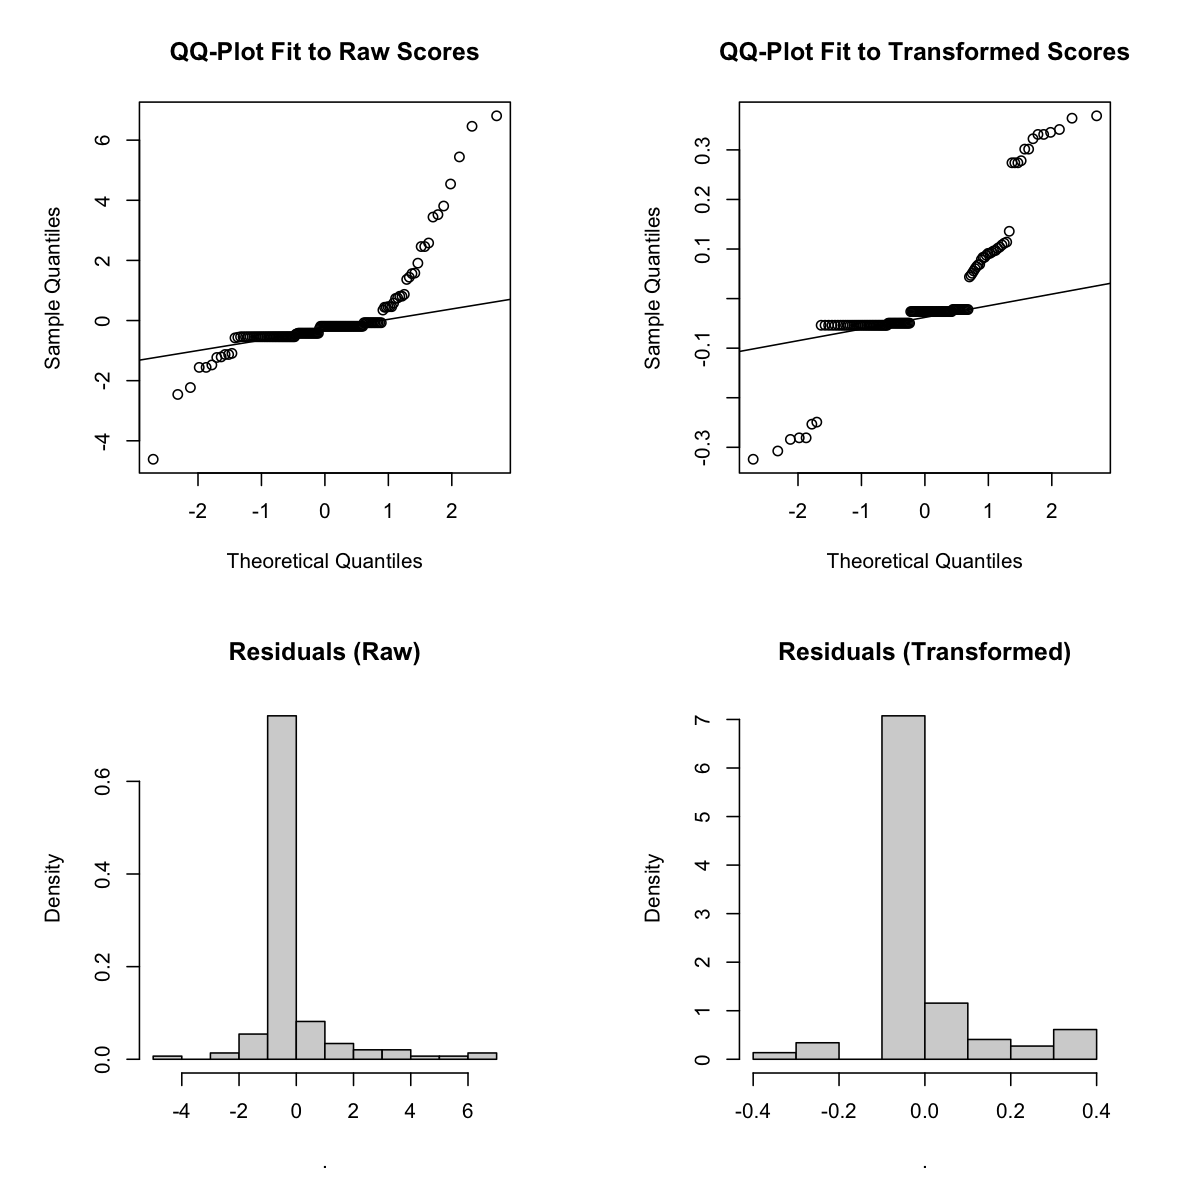

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)
rep$intention$emm_back
rep$intention$emm_diff_back
plot_qqs_hist(rep$intention)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.17 0.131 219     1.93     2.45
 Control       1.93 0.123 219     1.71     2.20

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.678) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.241 0.158 219   1.530  0.1275

Results are averaged over the levels of: wave 

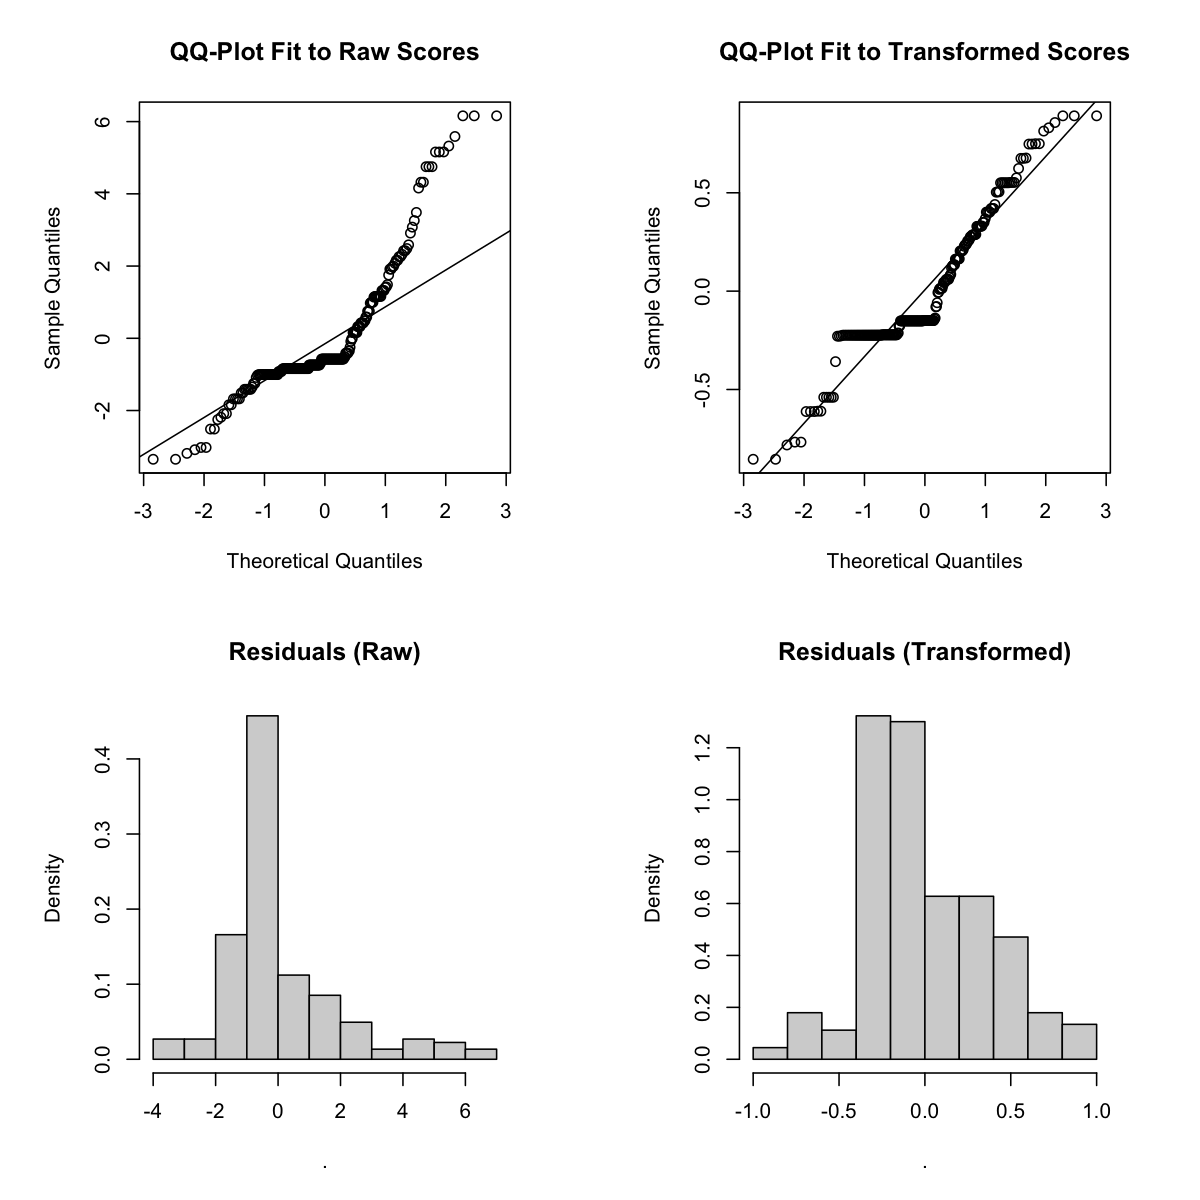

In [7]:
non_rep$intention$emm_back
non_rep$intention$emm_diff_back
plot_qqs_hist(non_rep$intention)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.48 0.0775 143     1.34     1.66
 Control       1.30 0.0605 143     1.20     1.44

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -1.814) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control    0.177 0.0822 143   2.159  0.0325

Results are averaged over the levels of: wave 

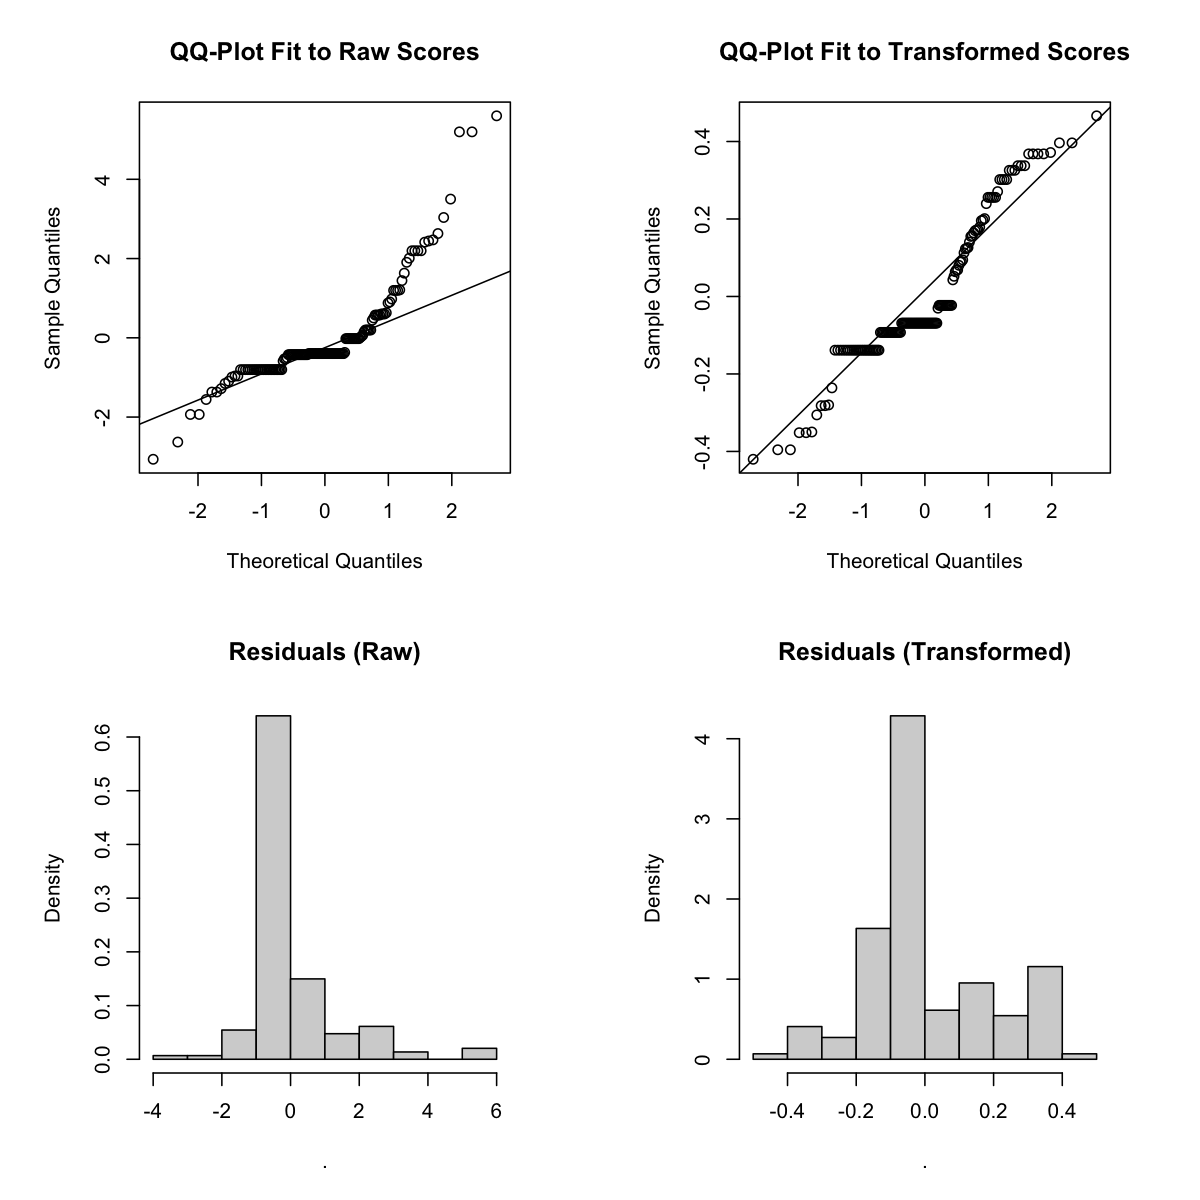

In [8]:
rep$encourage$emm_back
rep$encourage$emm_diff_back
plot_qqs_hist(rep$encourage)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.57 0.143 220     2.30     2.87
 Control       2.30 0.150 220     2.02     2.62

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.121) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.269 0.189 220   1.427  0.1550

Results are averaged over the levels of: wave 

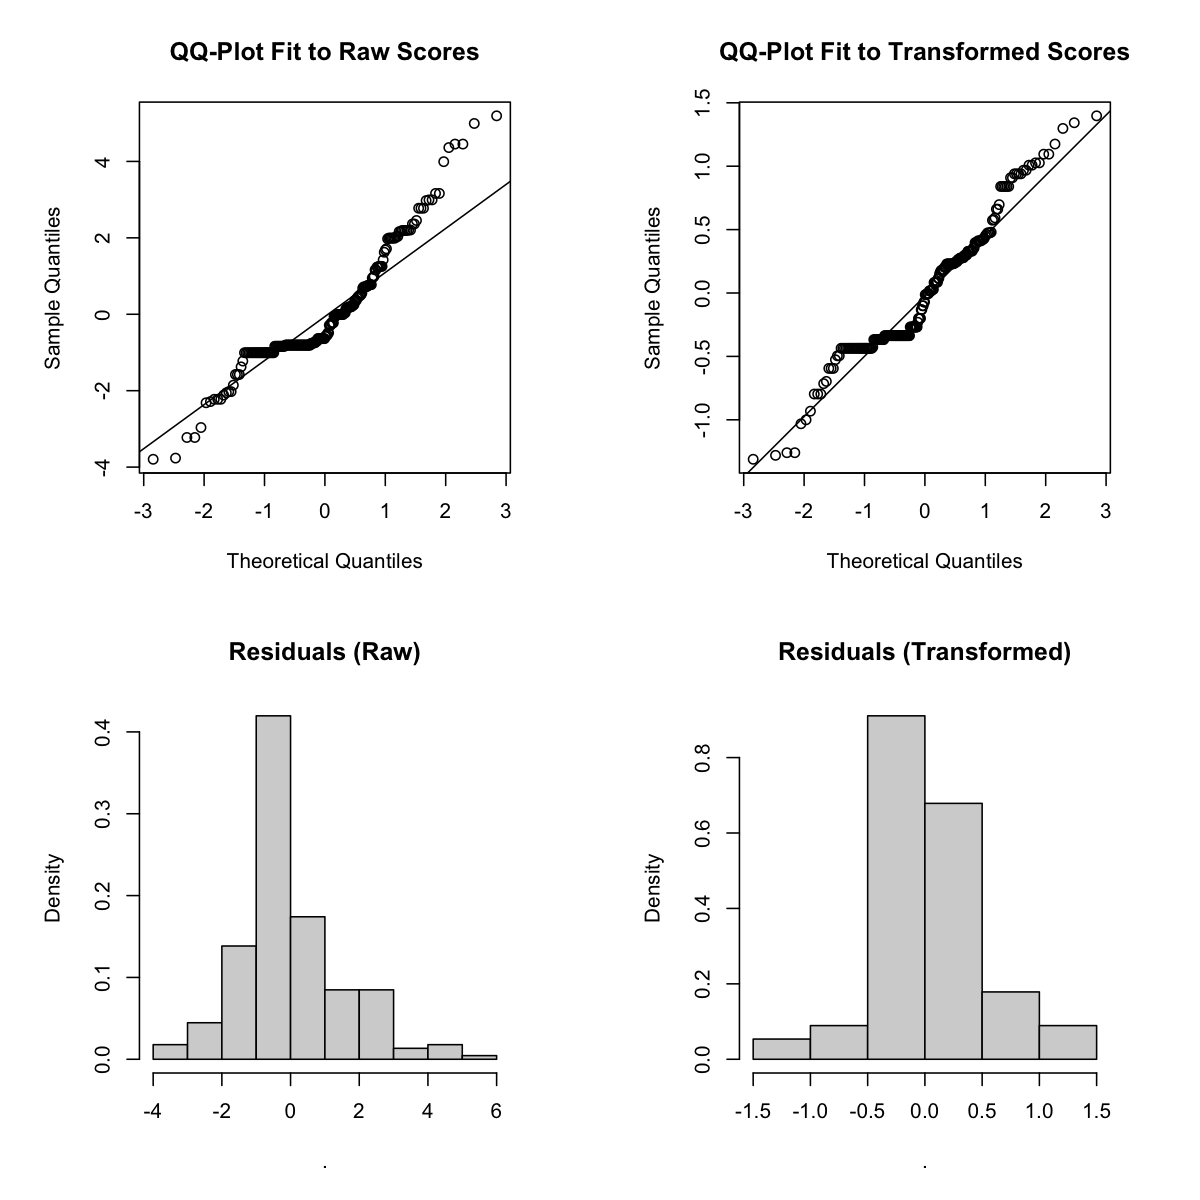

In [9]:
non_rep$encourage$emm_back
non_rep$encourage$emm_diff_back
plot_qqs_hist(non_rep$encourage)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.80 0.0791 143     1.65     1.96
 Control       1.73 0.0857 143     1.57     1.91

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.377) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.069 0.111 143   0.622  0.5352

Results are averaged over the levels of: wave 

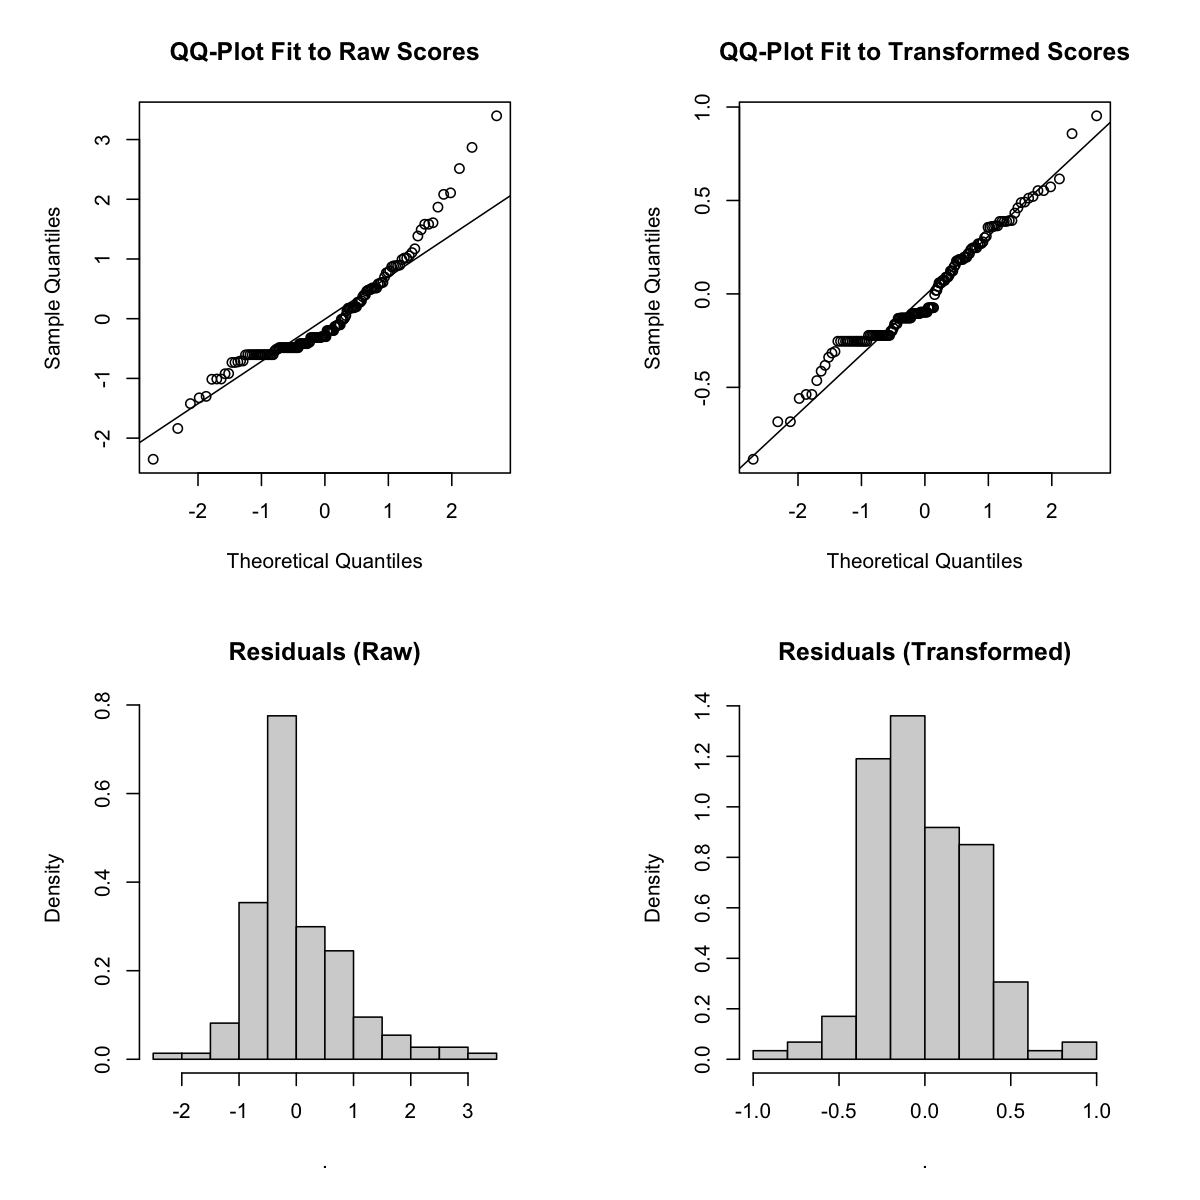

In [10]:
rep$sp_confidence$emm_back
rep$sp_confidence$emm_diff_back
plot_qqs_hist(rep$sp_confidence)

 group     response     SE  df lower.CL upper.CL
 Treatment     2.44 0.0784 220     2.29     2.60
 Control       2.42 0.0937 220     2.24     2.61

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.352) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control   0.0213 0.115 220   0.185  0.8538

Results are averaged over the levels of: wave 

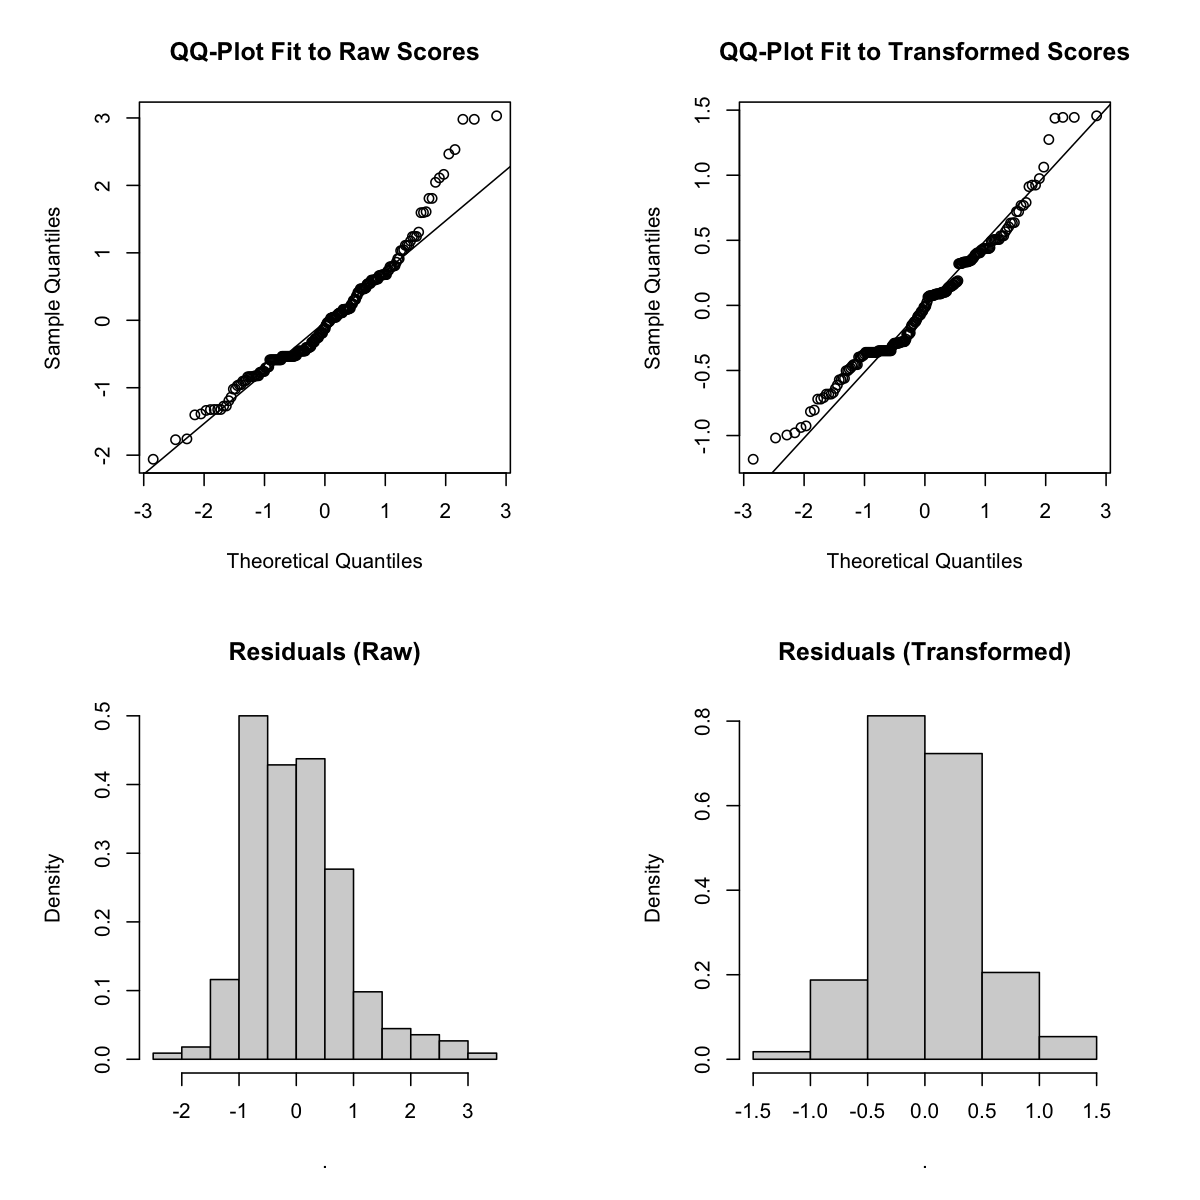

In [11]:
non_rep$sp_confidence$emm_back
non_rep$sp_confidence$emm_diff_back
plot_qqs_hist(non_rep$sp_confidence)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.83 0.0885 143     1.67     2.02
 Control       1.71 0.0910 143     1.54     1.91

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.412) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.124 0.121 143   1.025  0.3069

Results are averaged over the levels of: wave 

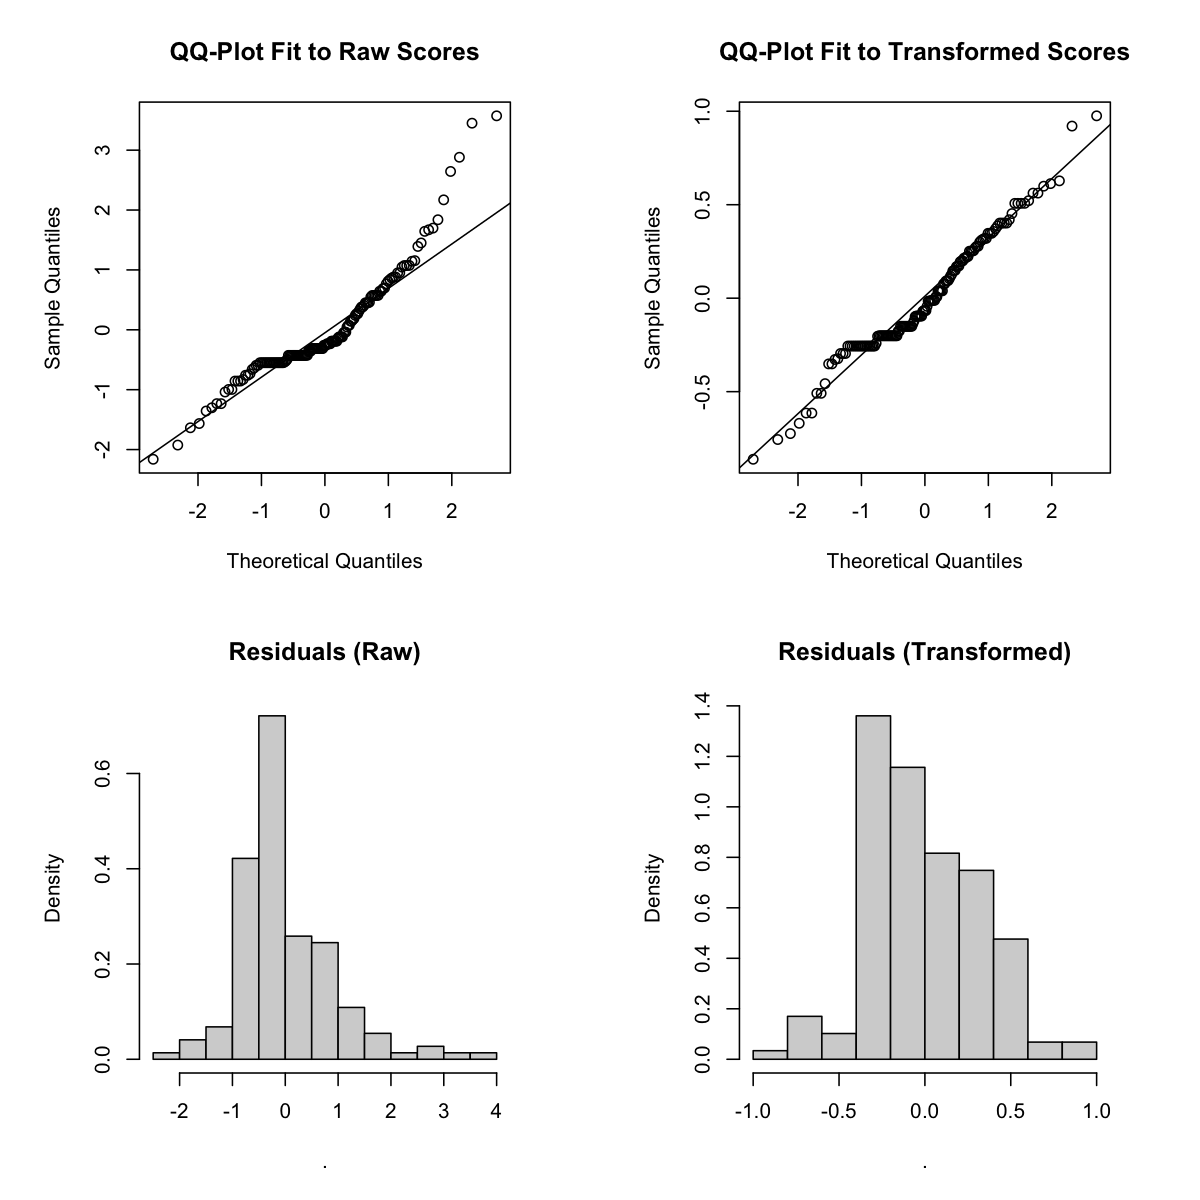

In [12]:
rep$sp_complacency$emm_back
rep$sp_complacency$emm_diff_back
plot_qqs_hist(rep$sp_complacency)

 group     response     SE  df lower.CL upper.CL
 Treatment     2.67 0.0829 220     2.51     2.84
 Control       2.58 0.0971 220     2.40     2.78

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.561) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control   0.0876 0.121 220   0.726  0.4689

Results are averaged over the levels of: wave 

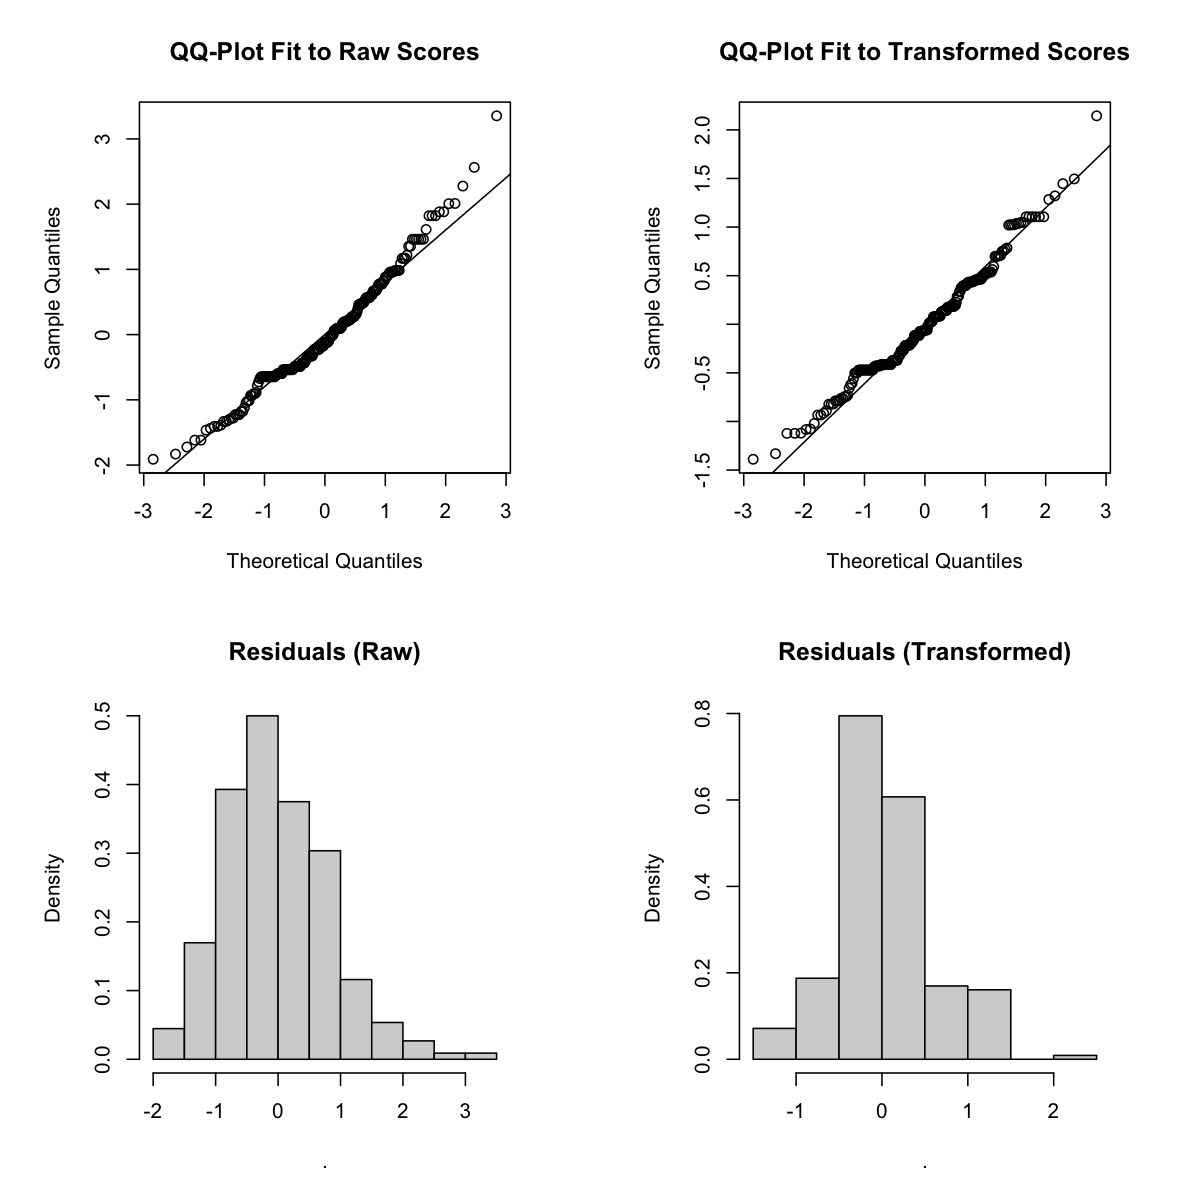

In [13]:
non_rep$sp_complacency$emm_back
non_rep$sp_complacency$emm_diff_back
plot_qqs_hist(non_rep$sp_complacency)

### Political Views

In [14]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + #phi_trust_cat +
                      #republican + phi_trust_cat +
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + #phi_trust_cat +
                                  #republican + phi_trust_cat +
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                      
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

In [15]:
vcf_data %>% group_by(conservative) %>% count()
vcf_data %>% group_by(conservative, group) %>% count()

conservative n  
1 nonconserv   203
2 conserv      168

conservative group     n  
1 nonconserv   Treatment 113
2 nonconserv   Control    90
3 conserv      Treatment  93
4 conserv      Control    75

In [16]:
summarize_intent(data = vcf_data %>% filter(conservative == "conserv") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(conservative == "conserv") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(conservative == "conserv") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(conservative == "conserv") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 93 1.4 (1.1) 1.9 (1.9) 0.4 (1.6) 0.21              0.009
2 Control   75 1.5 (1)   1.7 (1.5) 0.2 (1.2)   NA              0.128

group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 93 1.4 (1)   2 (1.5)   0.6 (1.5) 0.52              0.000
2 Control   75 1.6 (1.3) 1.7 (1.4) 0.1 (1.2)   NA              0.629

group     N  baseline  6_wk    mean_diff change_score_diff p    
1 Treatment 93 1.7 (0.8) 2 (1.1) 0.3 (0.8) 0.06              0.001
2 Control   75 1.7 (0.8) 1.9 (1) 0.2 (0.8)   NA              0.016

group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 93 1.8 (0.8) 2 (1.1)   0.3 (1)   0.12              0.011
2 Control   75 1.8 (0.9) 1.9 (1.1) 0.1 (0.9)   NA              0.172

In [17]:
summarize_intent(data = vcf_data %>% filter(conservative == "nonconserv") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(conservative == "nonconserv") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(conservative == "nonconserv") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(conservative == "nonconserv") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 113 2.1 (1.6) 2.9 (2.3) 0.8 (2)   0.38              0.000
2 Control    90 1.9 (1.4) 2.4 (2.1) 0.4 (1.5)   NA              0.007

group     N   baseline  6_wk    mean_diff change_score_diff p    
1 Treatment 113 2.5 (1.7) 3 (2)   0.5 (1.6) -0.02             0.002
2 Control    90 2.1 (1.6) 2.6 (2) 0.5 (1.5)    NA             0.002

group     N   baseline 6_wk      mean_diff change_score_diff p
1 Treatment 113 2.3 (1)  2.7 (1.3) 0.4 (0.9) 0.02              0
2 Control    90 2 (1)    2.4 (1.2) 0.4 (0.8)   NA              0

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 113 2.5 (1.1) 2.9 (1.3) 0.4 (0.9) 0.05              0.000
2 Control    90 2.3 (1.3) 2.6 (1.3) 0.3 (0.9)   NA              0.001

In [18]:
conserv <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(conservative == "conserv"), 
                label = "Conservative", pad = 0.6)

non_conserv <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(conservative != "conserv"), 
                label = "Non-Conservative", pad = 0.6)

conserv$tbl
non_conserv$tbl

[1] "Intentions to Vaccinate (mean = 0.047; 95% CI = -0.062, 0.157; P = 0.3952)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.223; 95% CI = 0.043, 0.403; P = 0.0152)"
[3] "COVID-19 Vaccine Confidence (mean = 0.056; 95% CI = -0.146, 0.258; P = 0.5839)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.097; 95% CI = -0.12, 0.314; P = 0.3785)"

[1] "Intentions to Vaccinate (mean = 0.345; 95% CI = 0.003, 0.688; P = 0.048)"                      
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.175; 95% CI = -0.222, 0.571; P = 0.3857)"
[3] "COVID-19 Vaccine Confidence (mean = 0.038; 95% CI = -0.206, 0.281; P = 0.7599)"                
[4] "COVID-19 Vaccine Complacency (mean = 0.096; 95% CI = -0.152, 0.345; P = 0.4463)"

#### ANCOVA Model Evaluation

 group     response     SE  df lower.CL upper.CL
 Treatment     1.37 0.0534 163     1.28     1.49
 Control       1.32 0.0519 163     1.23     1.44

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -2.593) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control   0.0474 0.0556 163   0.852  0.3952

Results are averaged over the levels of: wave 

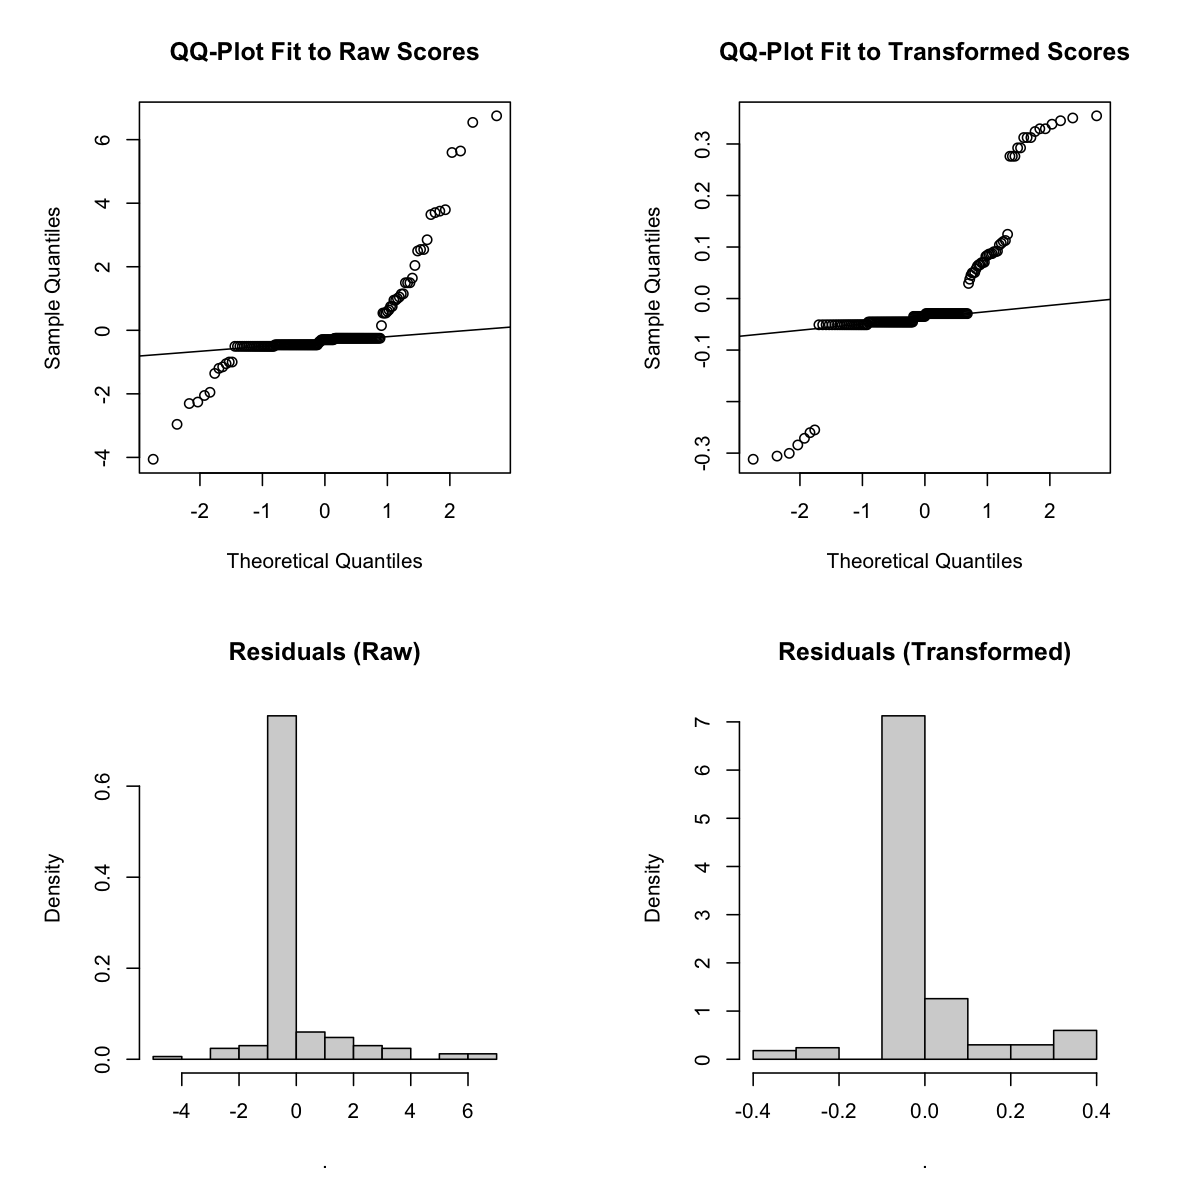

In [19]:
conserv$intention$emm_back
conserv$intention$emm_diff_back
plot_qqs_hist(conserv$intention)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.29 0.145 199     2.03     2.61
 Control       1.95 0.130 199     1.72     2.23

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.569) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.345 0.174 199   1.990  0.0480

Results are averaged over the levels of: wave 

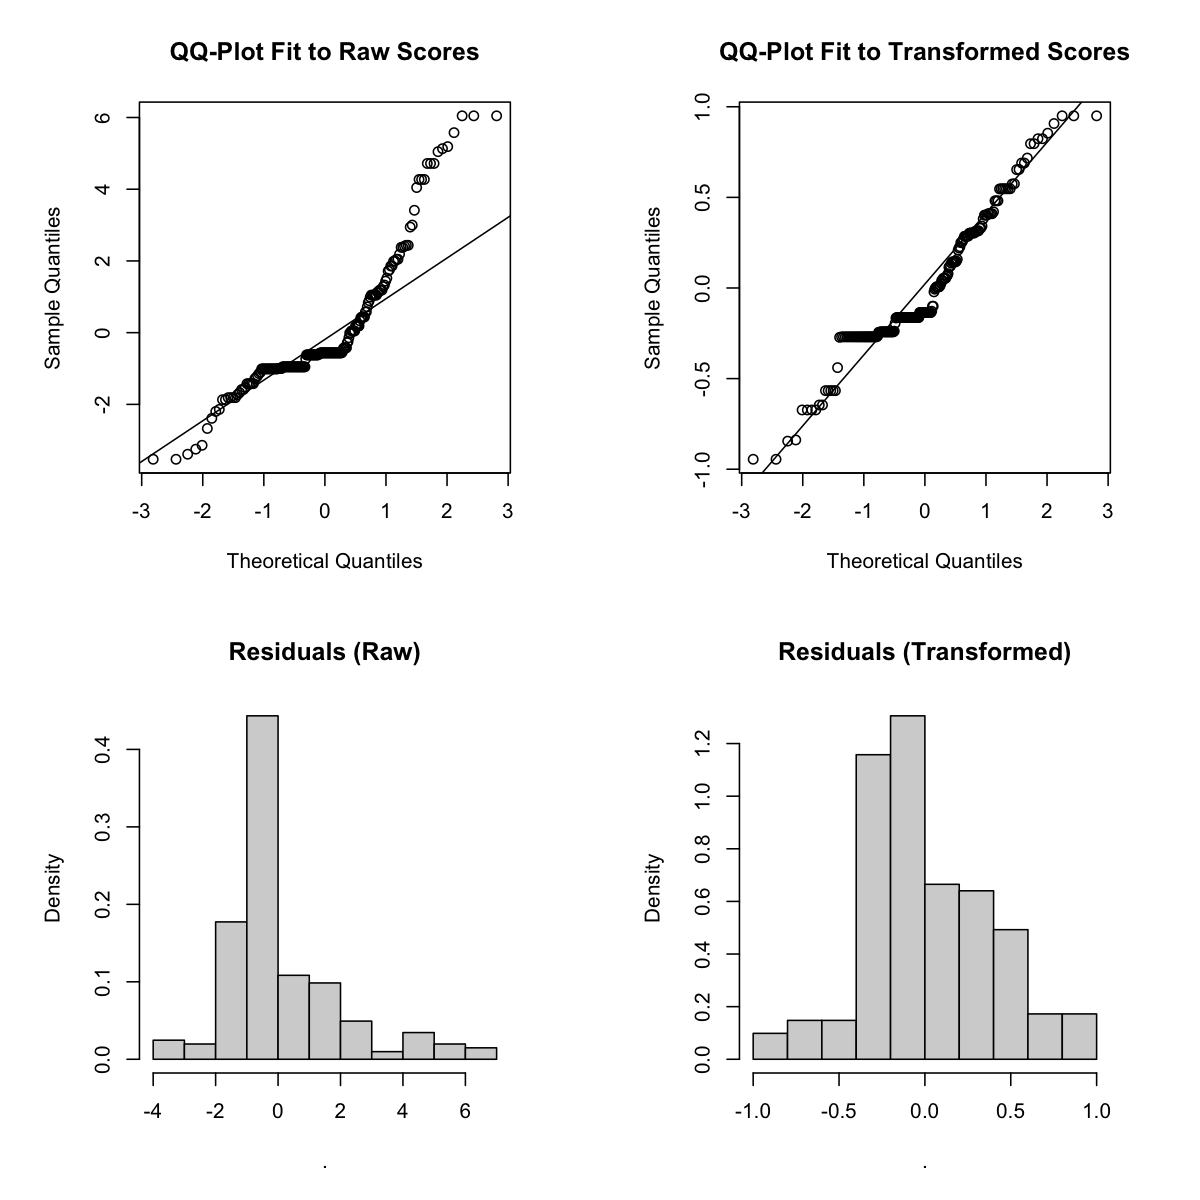

In [20]:
non_conserv$intention$emm_back
non_conserv$intention$emm_diff_back
plot_qqs_hist(non_conserv$intention)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.55 0.0874 164     1.40     1.75
 Control       1.33 0.0637 164     1.22     1.47

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -1.547) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.223 0.091 164   2.452  0.0152

Results are averaged over the levels of: wave 

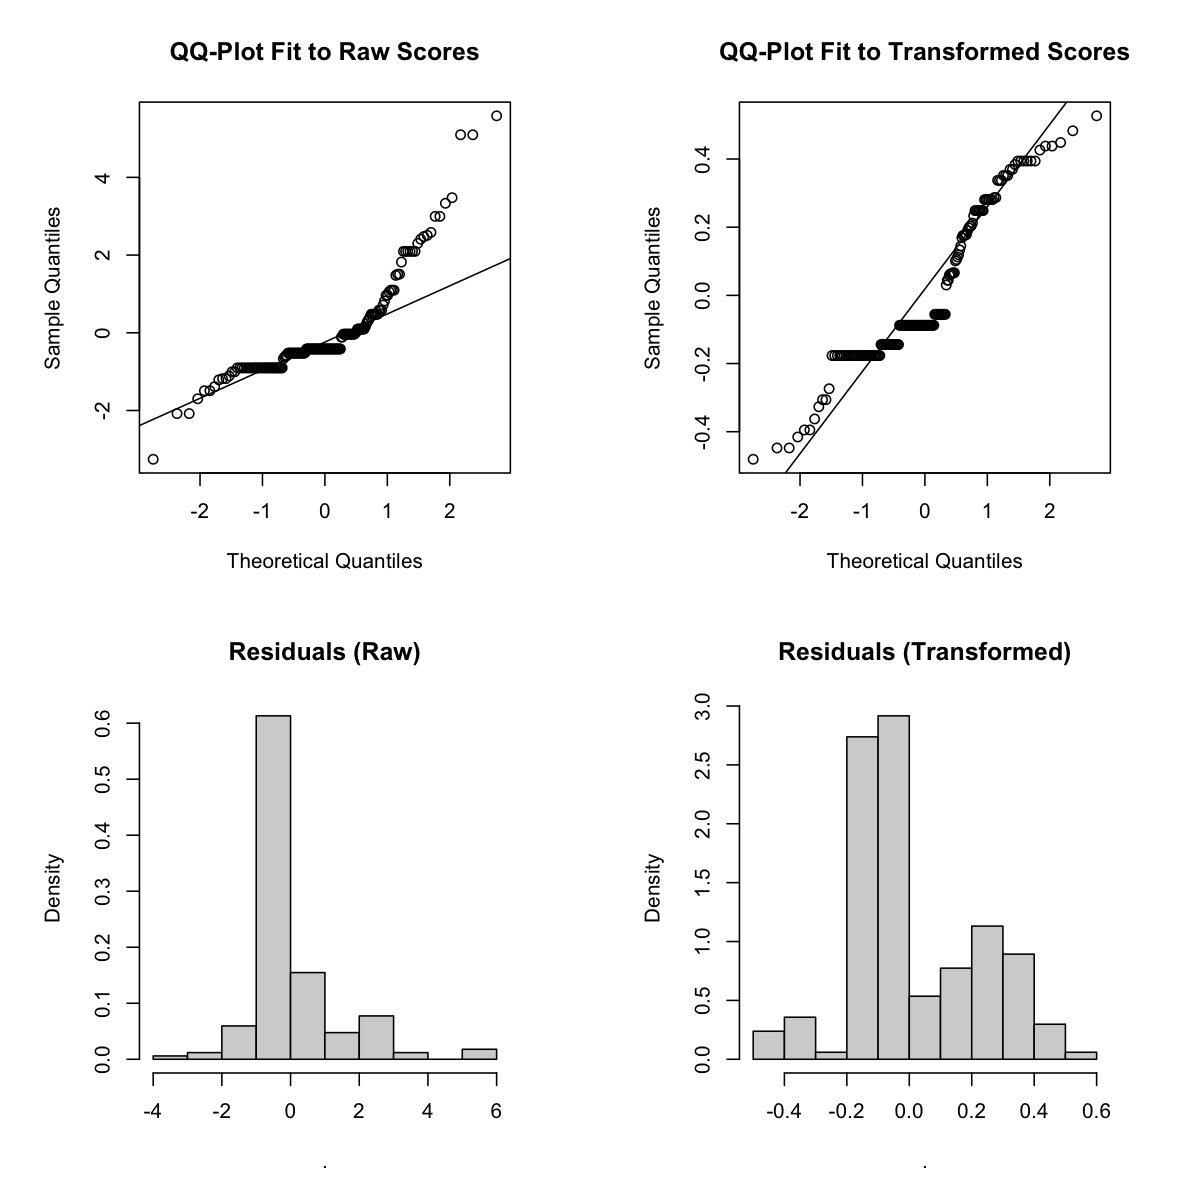

In [21]:
conserv$encourage$emm_back
conserv$encourage$emm_diff_back
plot_qqs_hist(conserv$encourage)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.55 0.146 199     2.28     2.86
 Control       2.38 0.162 199     2.08     2.72

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.115) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.175 0.201 199   0.869  0.3857

Results are averaged over the levels of: wave 

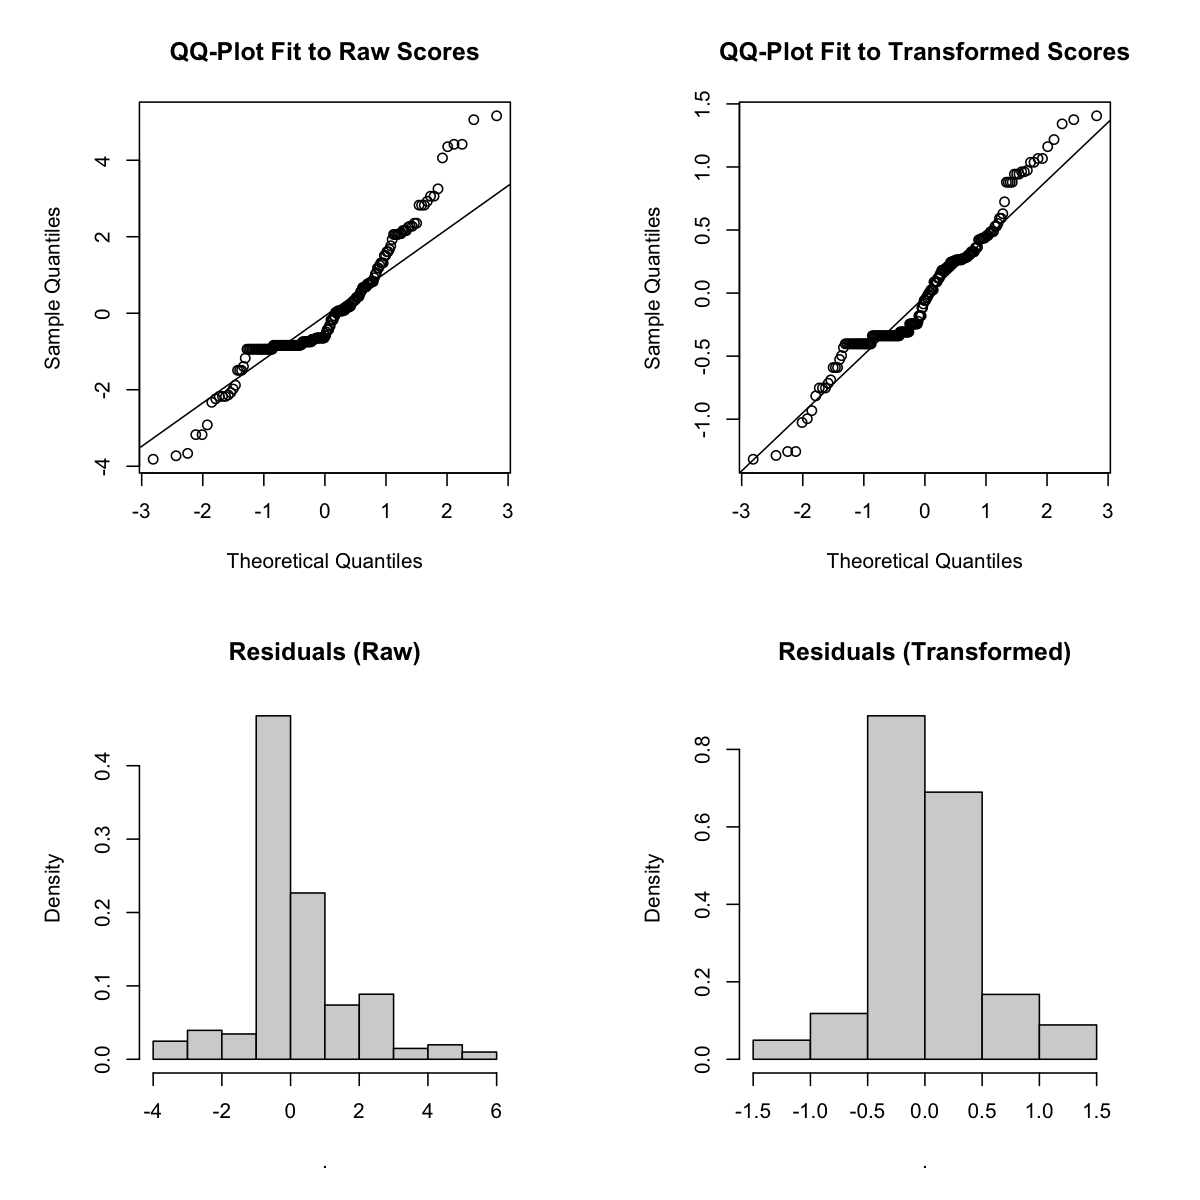

In [22]:
non_conserv$encourage$emm_back
non_conserv$encourage$emm_diff_back
plot_qqs_hist(non_conserv$encourage)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.81 0.0731 164     1.67     1.96
 Control       1.75 0.0811 164     1.60     1.92

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.352) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.056 0.102 164   0.549  0.5839

Results are averaged over the levels of: wave 

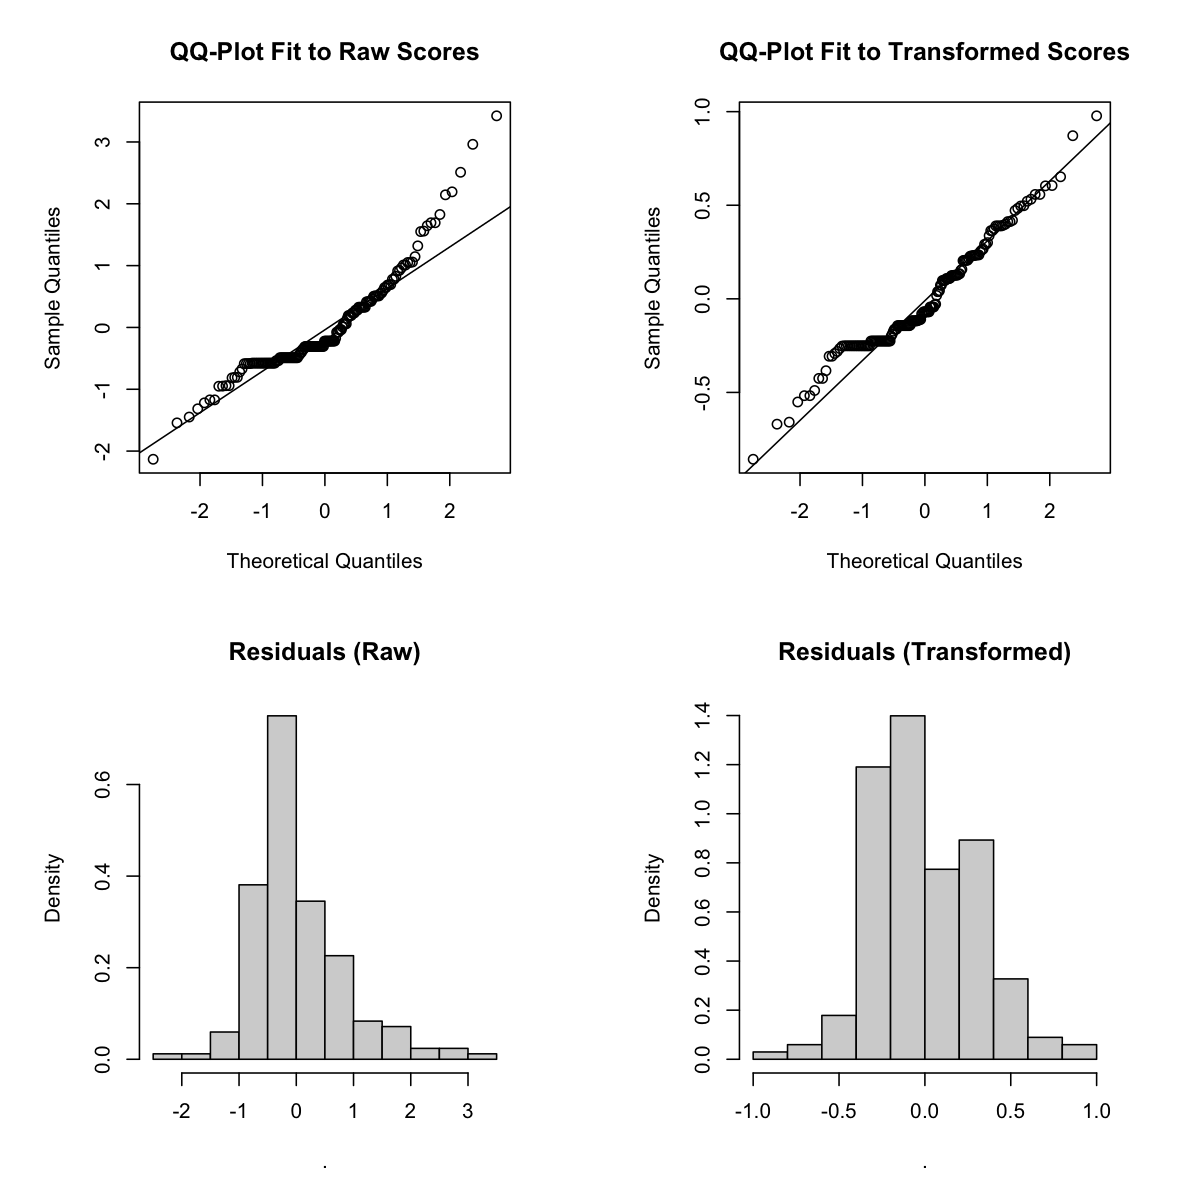

In [23]:
conserv$sp_confidence$emm_back
conserv$sp_confidence$emm_diff_back
plot_qqs_hist(conserv$sp_confidence)

 group     response     SE  df lower.CL upper.CL
 Treatment     2.51 0.0840 199     2.35     2.68
 Control       2.48 0.0983 199     2.29     2.67

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.444) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control   0.0378 0.124 199   0.306  0.7599

Results are averaged over the levels of: wave 

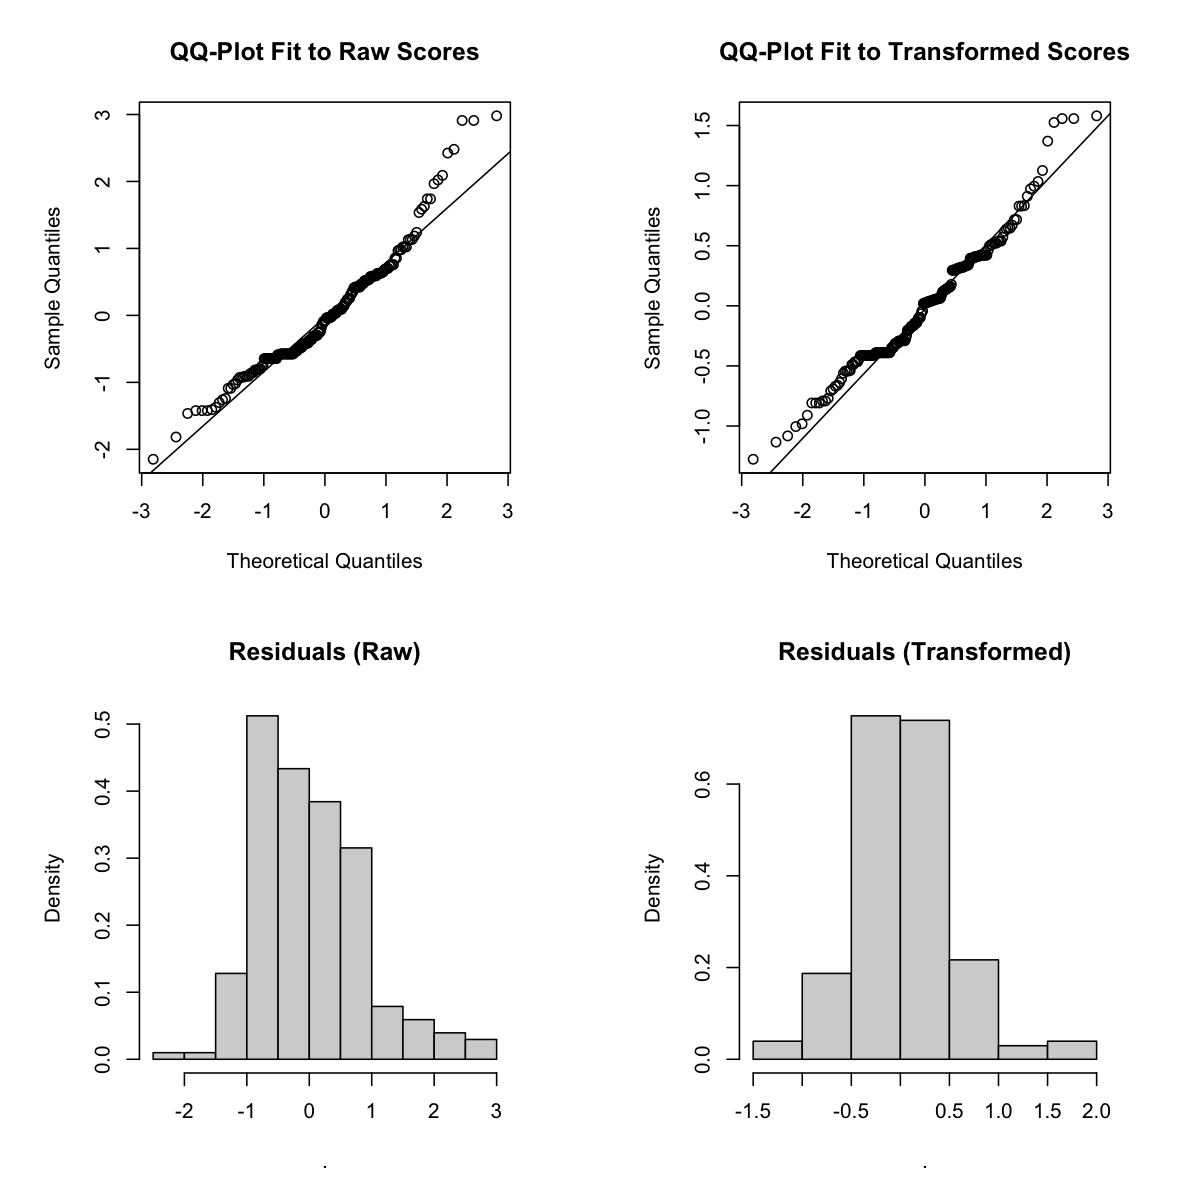

In [24]:
non_conserv$sp_confidence$emm_back
non_conserv$sp_confidence$emm_diff_back
plot_qqs_hist(non_conserv$sp_confidence)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.82 0.0804 164     1.67     1.99
 Control       1.73 0.0858 164     1.57     1.91

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.422) scale 

 contrast            estimate   SE  df t.ratio p.value
 Treatment - Control    0.097 0.11 164   0.883  0.3785

Results are averaged over the levels of: wave 

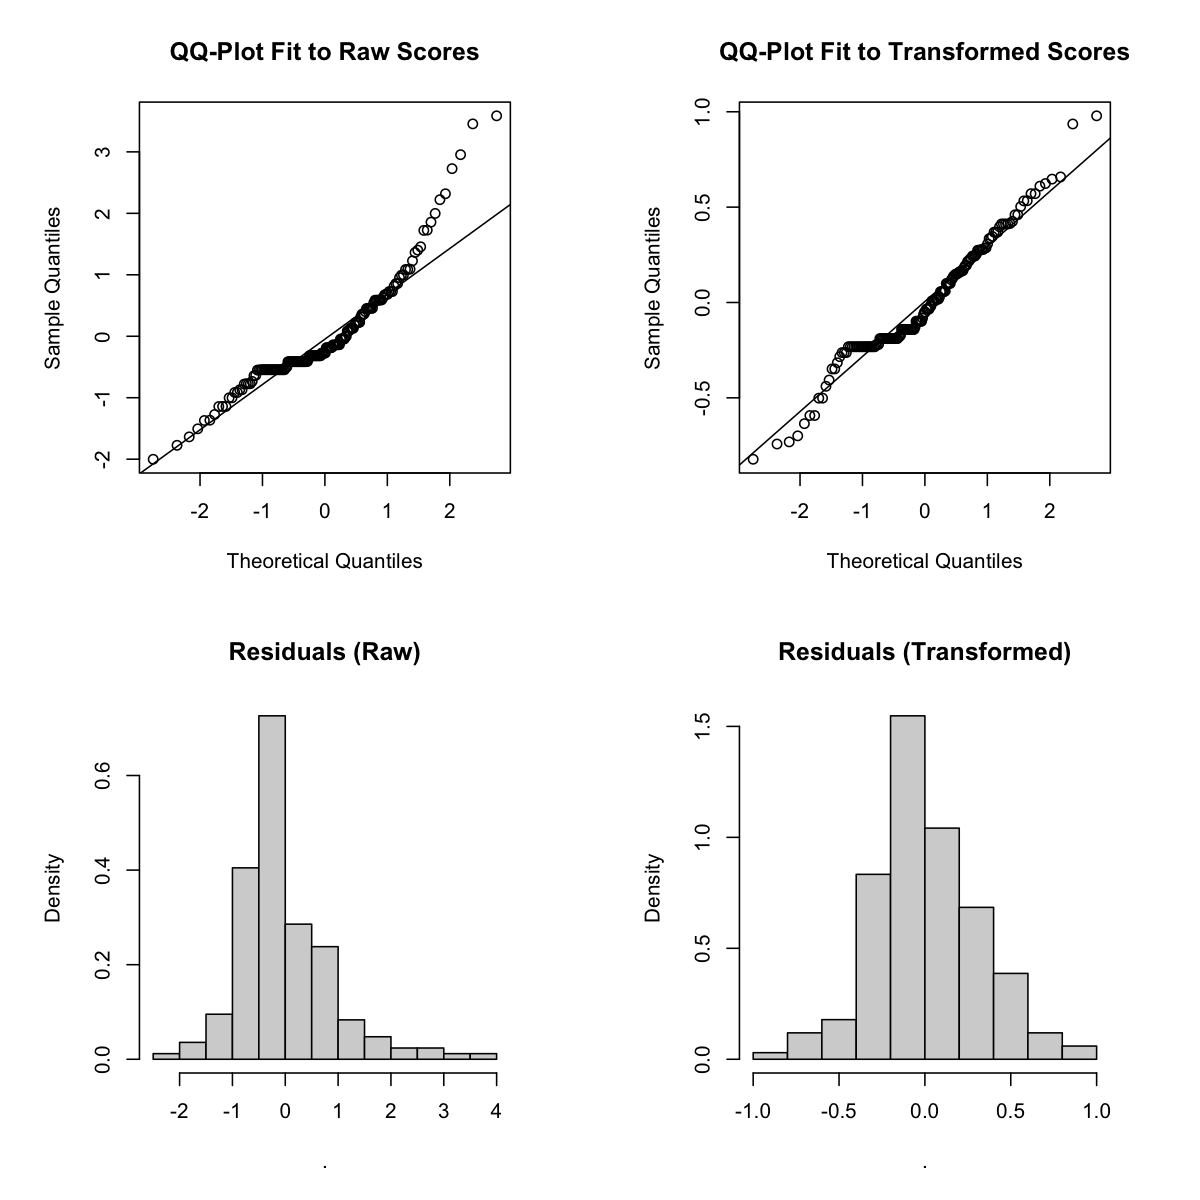

In [25]:
conserv$sp_complacency$emm_back
conserv$sp_complacency$emm_diff_back
plot_qqs_hist(conserv$sp_complacency)

 group     response     SE  df lower.CL upper.CL
 Treatment     2.77 0.0865 199     2.60     2.94
 Control       2.67 0.0997 199     2.48     2.87

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.669) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control   0.0961 0.126 199   0.763  0.4463

Results are averaged over the levels of: wave 

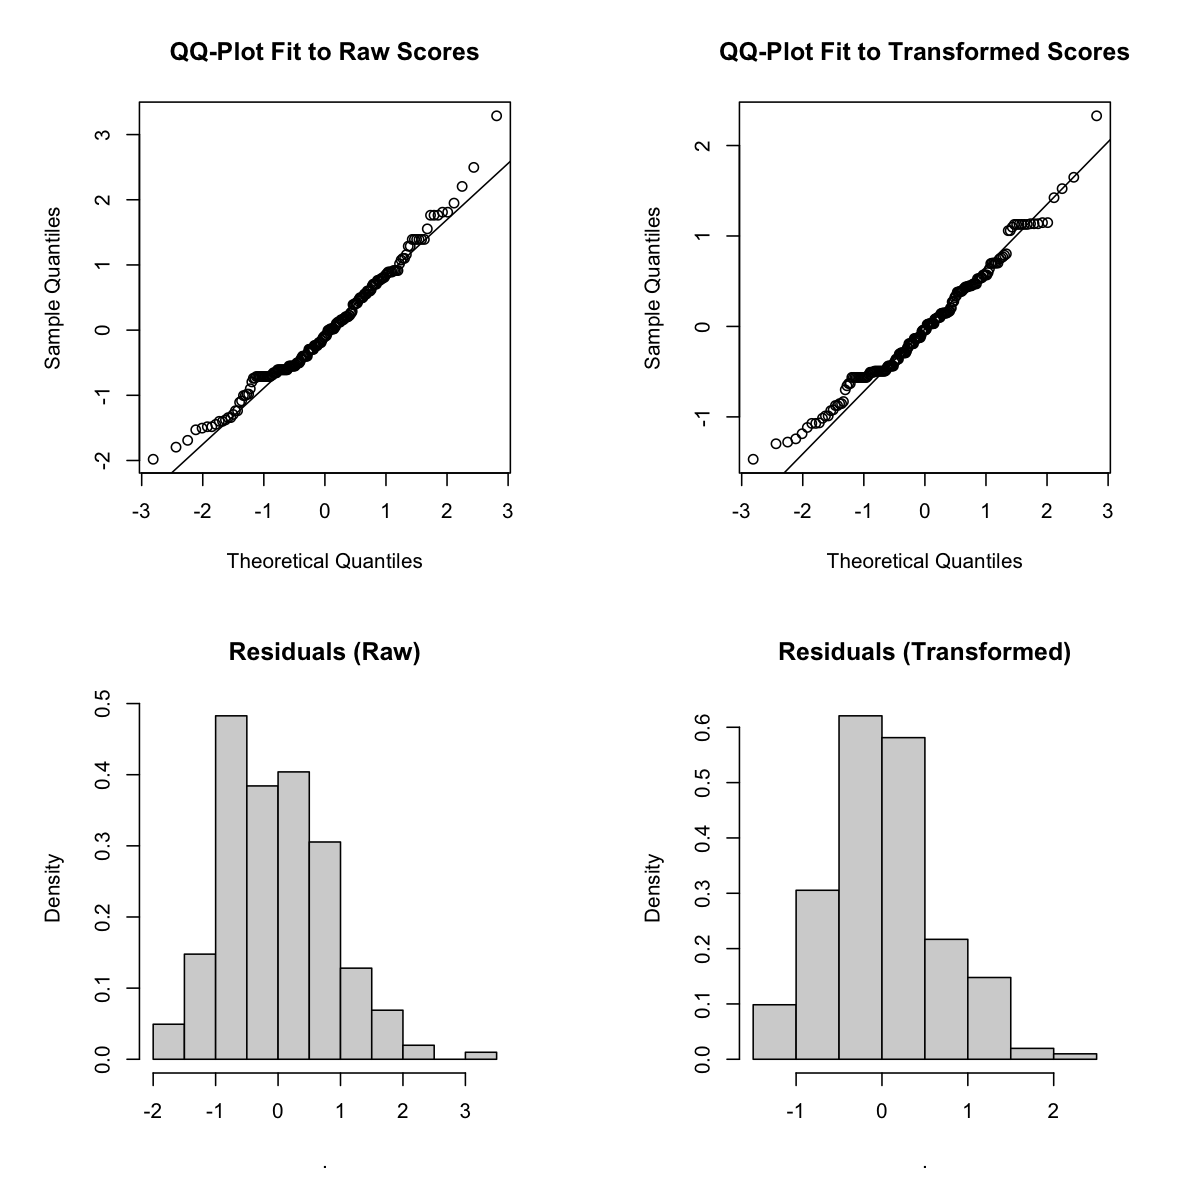

In [26]:
non_conserv$sp_complacency$emm_back
non_conserv$sp_complacency$emm_diff_back
plot_qqs_hist(non_conserv$sp_complacency)

### Governmental Institution Trust Views

In [27]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      #republican + conservative + 
                      #employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  #republican + conservative +  
                                  #employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                 
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

In [28]:
vcf_data %>% group_by(gov_trust_cat) %>% count()
vcf_data %>% group_by(gov_trust_cat, group) %>% count()

gov_trust_cat n  
1 distrusting   177
2 trusting      194

gov_trust_cat group     n  
1 distrusting   Treatment 101
2 distrusting   Control    76
3 trusting      Treatment 105
4 trusting      Control    89

In [29]:
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "trusting") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "trusting") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "trusting") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "trusting") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 105 2.3 (1.7) 3.1 (2.5) 0.9 (2.2) 0.34              0.000
2 Control    89 2.1 (1.5) 2.6 (2.3) 0.5 (1.7)   NA              0.003

group     N   baseline  6_wk      mean_diff change_score_diff p   
1 Treatment 105 2.5 (1.7) 3.2 (1.9) 0.7 (1.9) 0.29              0.00
2 Control    89 2.4 (1.8) 2.8 (2)   0.4 (1.6)   NA              0.01

group     N   baseline 6_wk      mean_diff change_score_diff p
1 Treatment 105 2.4 (1)  2.9 (1.2) 0.6 (1)   0.15              0
2 Control    89 2.2 (1)  2.6 (1.2) 0.4 (1)     NA              0

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 105 2.5 (1.1) 3 (1.3)   0.5 (1.1) 0.16              0.000
2 Control    89 2.5 (1.2) 2.8 (1.3) 0.3 (0.9)   NA              0.002

In [30]:
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "distrusting") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "distrusting") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "distrusting") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(gov_trust_cat == "distrusting") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 101 1.3 (0.8) 1.7 (1.6) 0.4 (1.4) 0.3               0.004
2 Control    76 1.3 (0.8) 1.4 (1)   0.1 (0.9)  NA               0.313

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 101 1.5 (1.2) 1.9 (1.5) 0.3 (1.1) 0.18              0.005
2 Control    76 1.3 (0.8) 1.5 (1.1) 0.1 (1.1)   NA              0.241

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 101 1.7 (0.8) 1.9 (1)   0.2 (0.7) -0.07             0.007
2 Control    76 1.4 (0.6) 1.6 (0.8) 0.3 (0.6)    NA             0.001

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 101 1.8 (0.9) 2 (1)     0.1 (0.7)  0                0.027
2 Control    76 1.6 (0.9) 1.7 (0.9) 0.1 (0.8) NA                0.126

In [31]:
gov_distrust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(gov_trust_cat == "distrusting"), 
                label = "Distrusting", pad = 0.6)

gov_trust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(gov_trust_cat == "trusting"), 
                label = "Trusting", pad = 0.6)

gov_distrust$tbl
gov_trust$tbl

[1] "Intentions to Vaccinate (mean = 0.056; 95% CI = -0.005, 0.117; P = 0.0702)"                 
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.13; 95% CI = 0.02, 0.241; P = 0.0209)"
[3] "COVID-19 Vaccine Confidence (mean = -0.03; 95% CI = -0.194, 0.134; P = 0.7176)"             
[4] "COVID-19 Vaccine Complacency (mean = 0.047; 95% CI = -0.142, 0.237; P = 0.6229)"

[1] "Intentions to Vaccinate (mean = 0.313; 95% CI = -0.117, 0.743; P = 0.1529)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.398; 95% CI = -0.07, 0.866; P = 0.0954)"
[3] "COVID-19 Vaccine Confidence (mean = 0.188; 95% CI = -0.088, 0.465; P = 0.1804)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.168; 95% CI = -0.119, 0.456; P = 0.2502)"

#### ANCOVA Model Evaluation

 group     response     SE  df lower.CL upper.CL
 Treatment     1.21 0.0322 172     1.16     1.29
 Control       1.16 0.0287 172     1.11     1.22

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -3.641) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control   0.0563 0.0309 172   1.822  0.0702

Results are averaged over the levels of: wave 

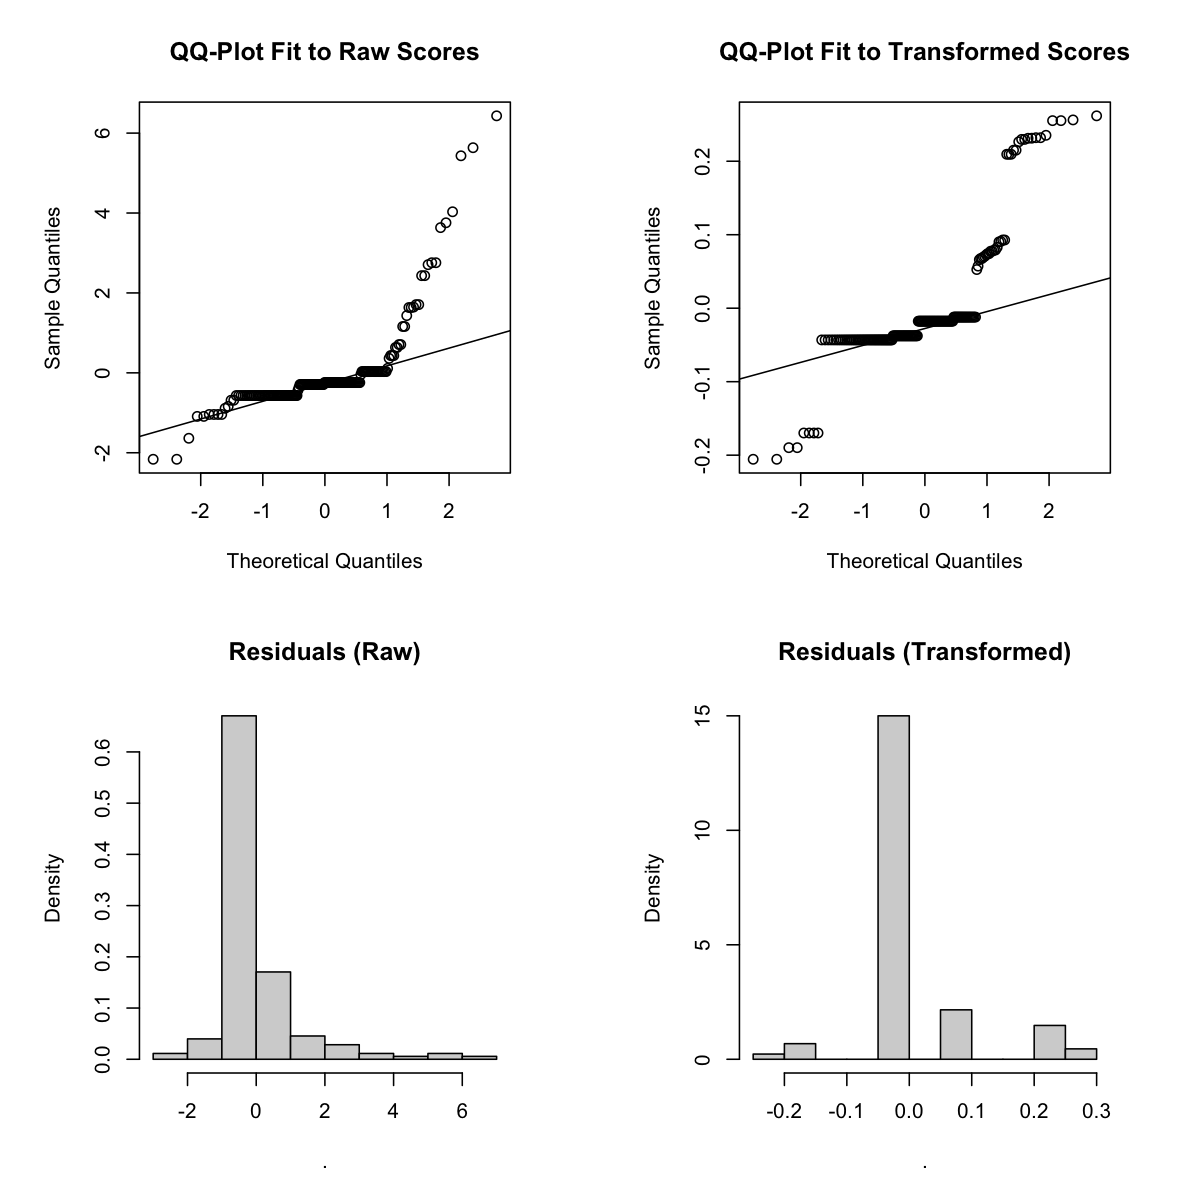

In [32]:
gov_distrust$intention$emm_back
gov_distrust$intention$emm_diff_back
plot_qqs_hist(gov_distrust$intention)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.59 0.175 190     2.28     2.97
 Control       2.28 0.168 190     1.98     2.65

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.38) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.313 0.218 190   1.435  0.1529

Results are averaged over the levels of: wave 

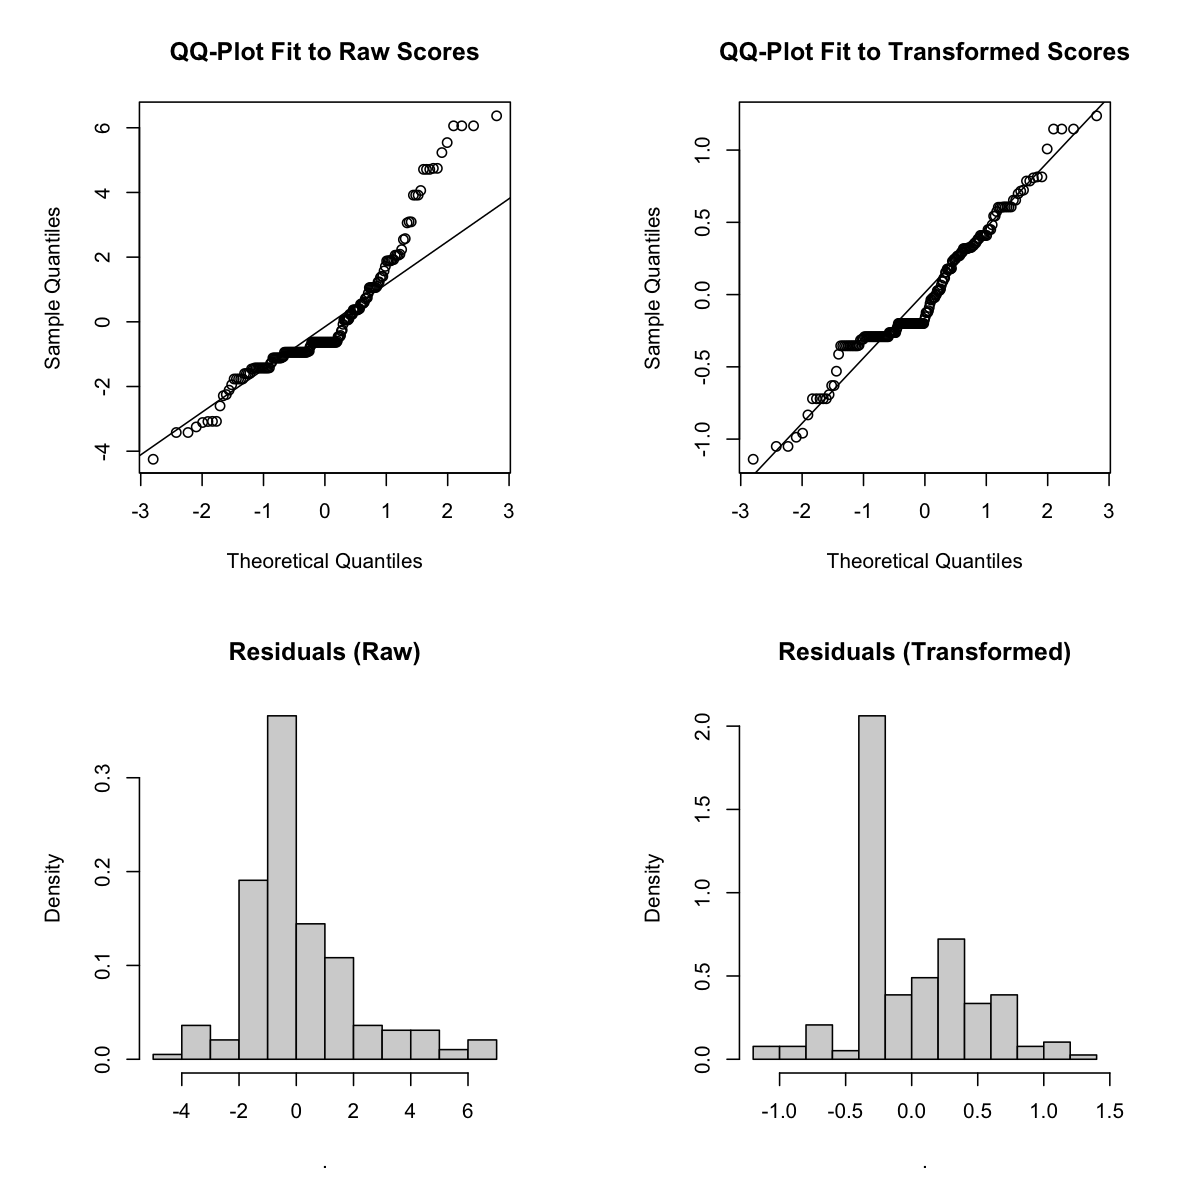

In [33]:
gov_trust$intention$emm_back
gov_trust$intention$emm_diff_back
plot_qqs_hist(gov_trust$intention)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.36 0.0517 173     1.27     1.48
 Control       1.23 0.0445 173     1.16     1.33

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -2.289) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control     0.13 0.056 173   2.331  0.0209

Results are averaged over the levels of: wave 

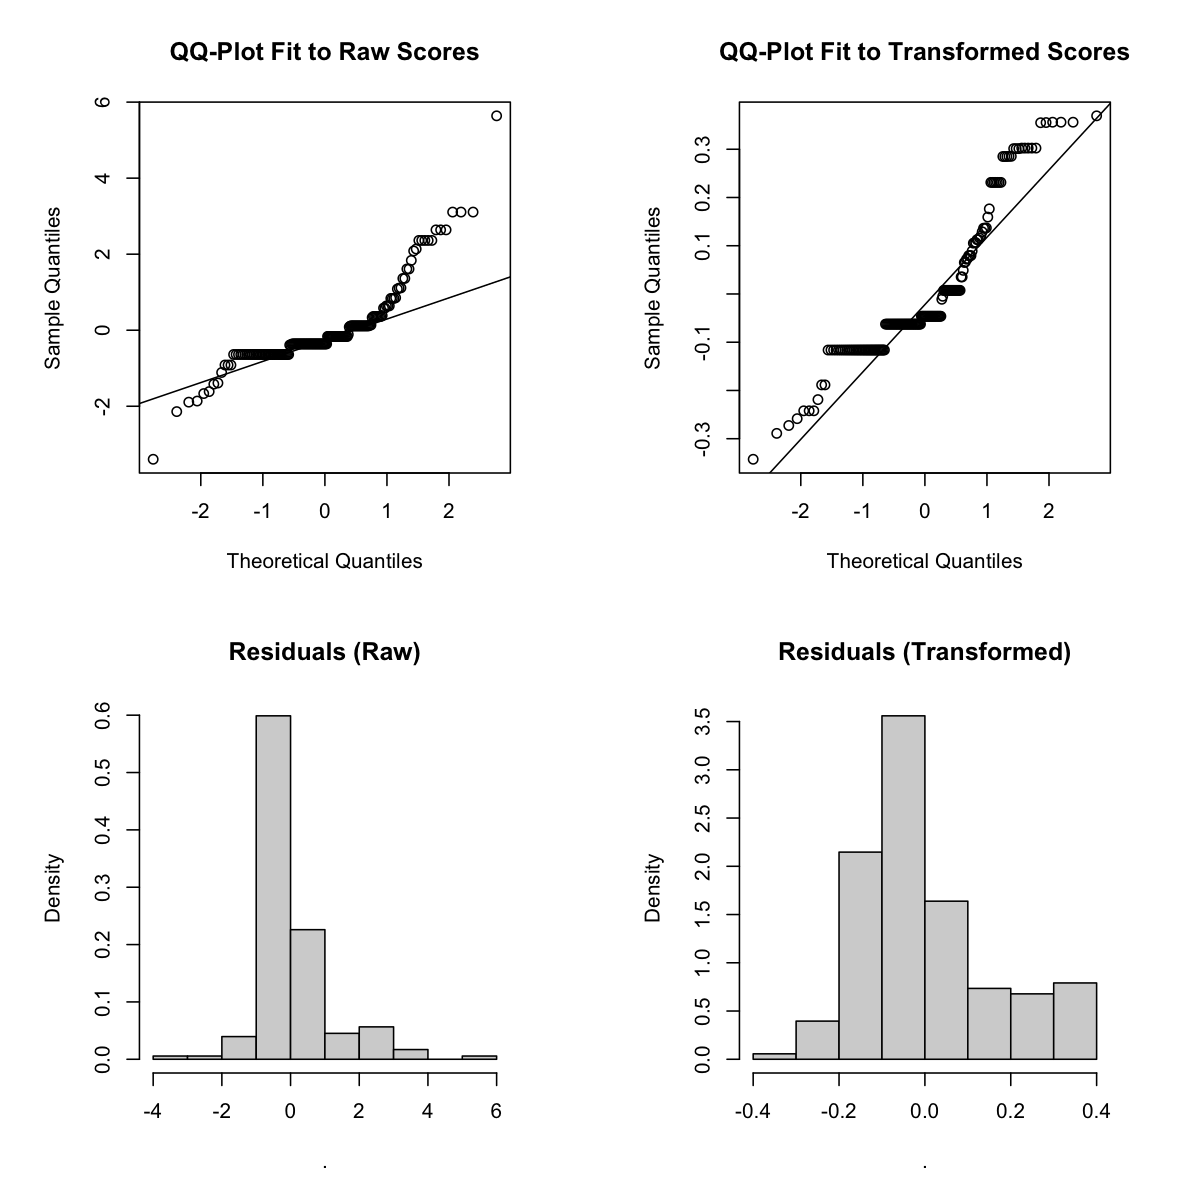

In [34]:
gov_distrust$encourage$emm_back
gov_distrust$encourage$emm_diff_back
plot_qqs_hist(gov_distrust$encourage)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.98 0.183 190     2.64     3.36
 Control       2.58 0.185 190     2.24     2.97

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.096) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.398 0.237 190   1.676  0.0954

Results are averaged over the levels of: wave 

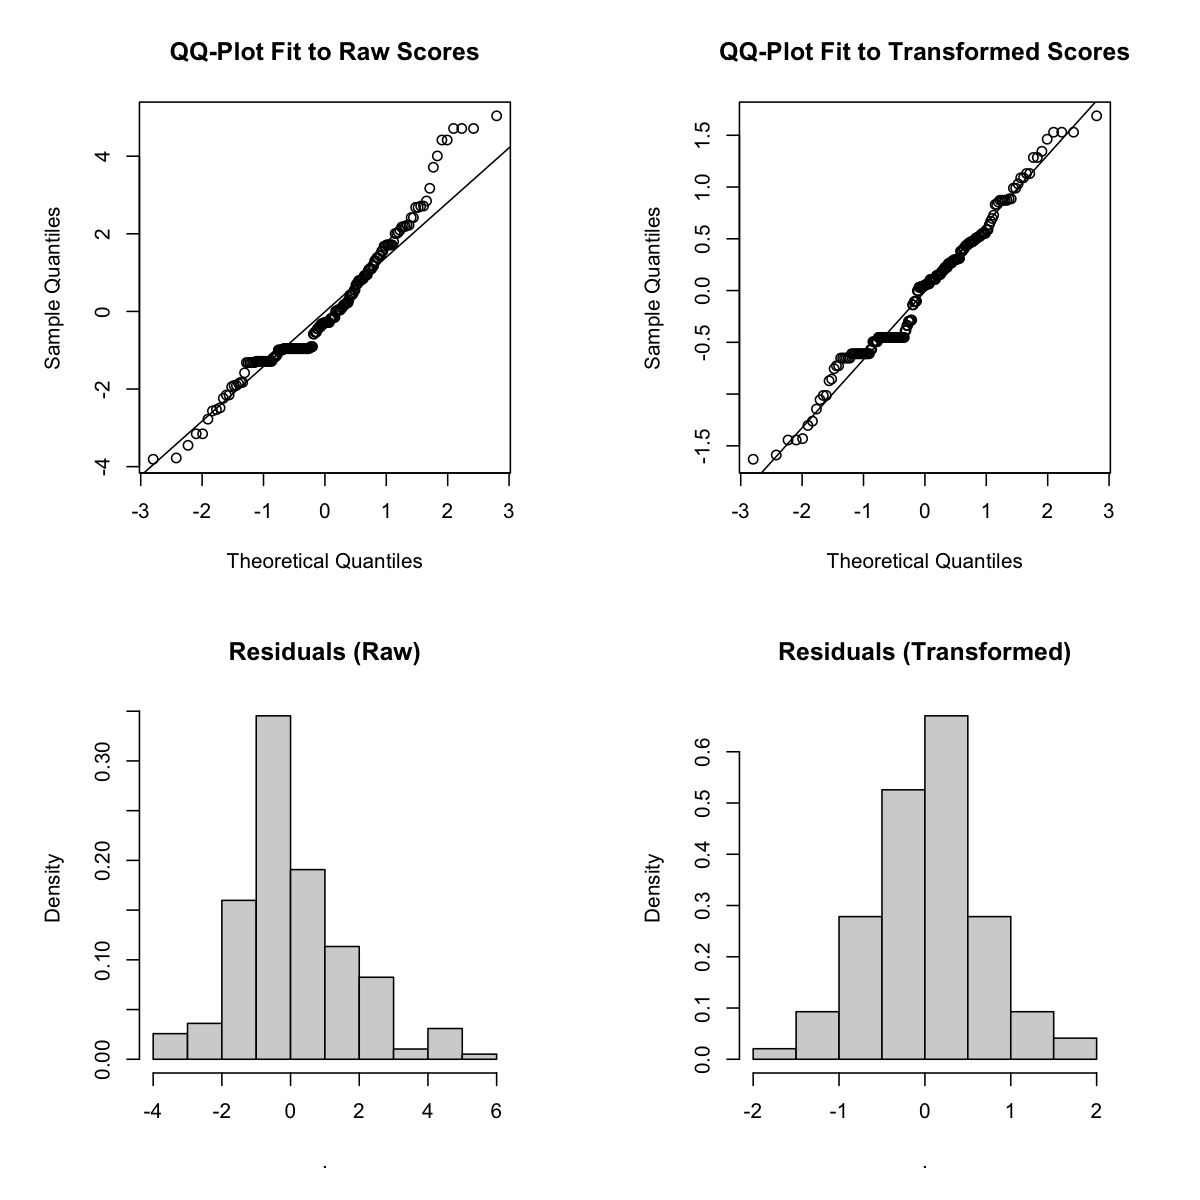

In [35]:
gov_trust$encourage$emm_back
gov_trust$encourage$emm_diff_back
plot_qqs_hist(gov_trust$encourage)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.62 0.0535 173     1.52     1.73
 Control       1.65 0.0680 173     1.52     1.79

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.475) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control    -0.03 0.0828 173  -0.362  0.7176

Results are averaged over the levels of: wave 

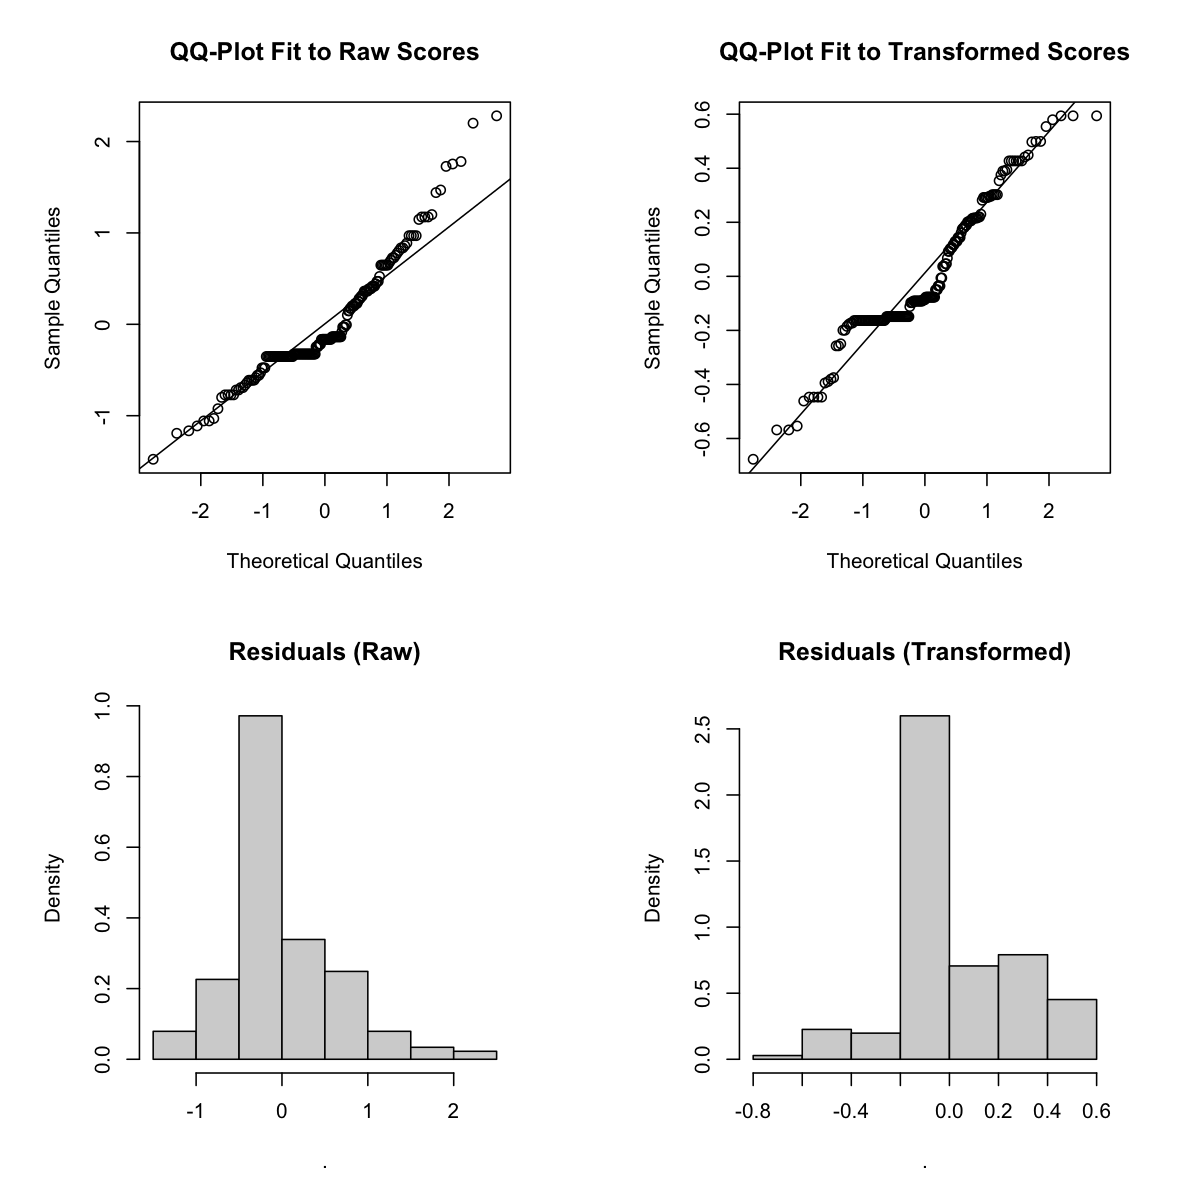

In [36]:
gov_distrust$sp_confidence$emm_back
gov_distrust$sp_confidence$emm_diff_back
plot_qqs_hist(gov_distrust$sp_confidence)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.79 0.100 190     2.59     2.99
 Control       2.60 0.112 190     2.38     2.82

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.53) scale 

 contrast            estimate   SE  df t.ratio p.value
 Treatment - Control    0.188 0.14 190   1.344  0.1804

Results are averaged over the levels of: wave 

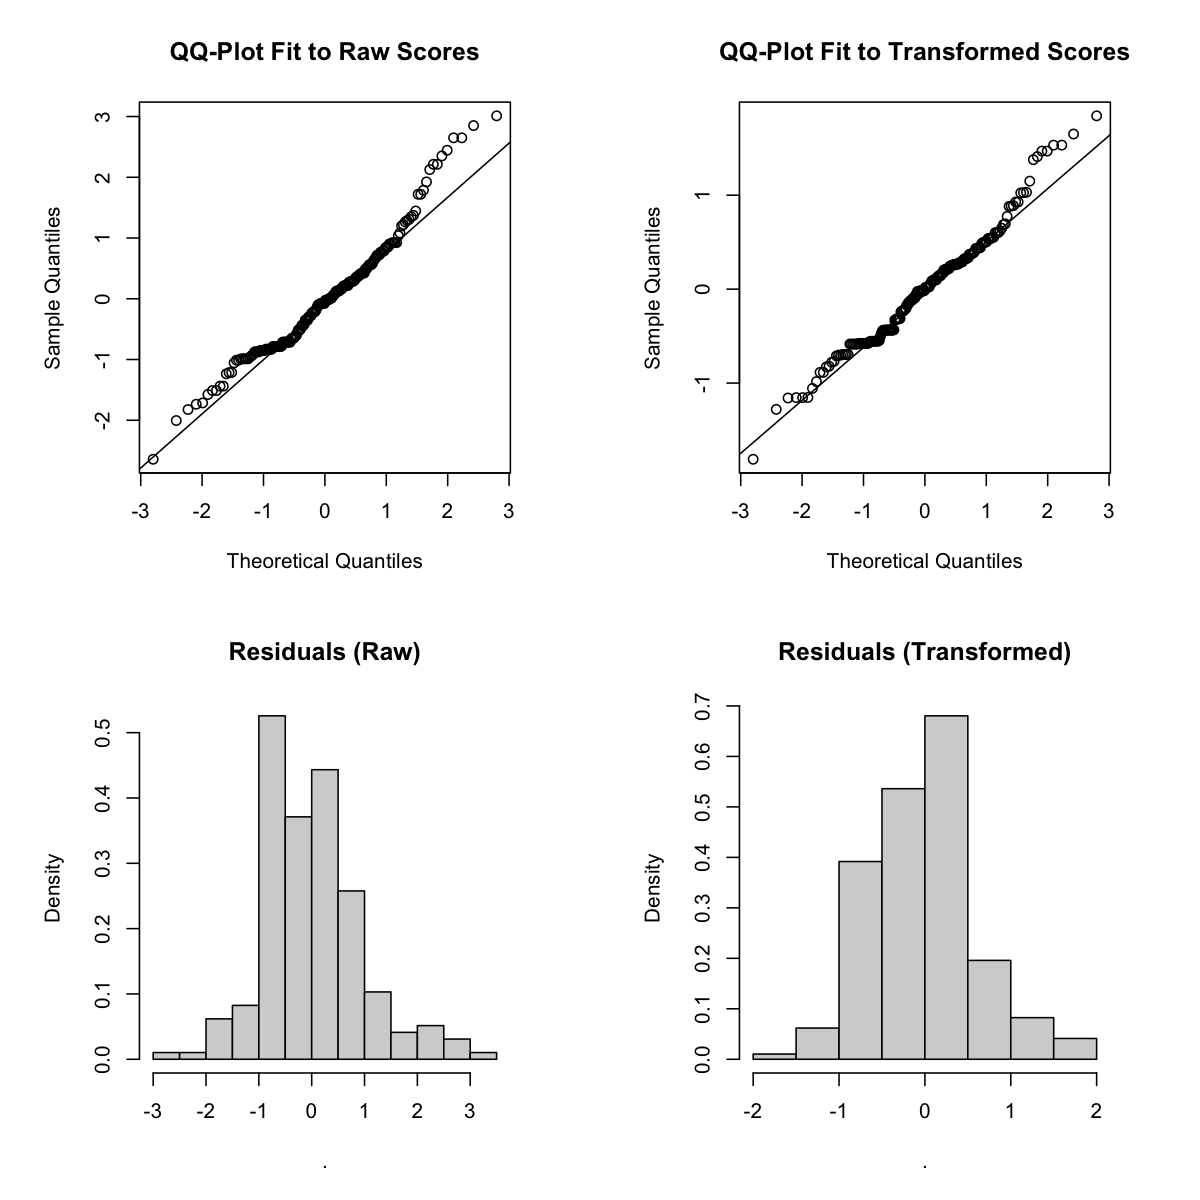

In [37]:
gov_trust$sp_confidence$emm_back
gov_trust$sp_confidence$emm_diff_back
plot_qqs_hist(gov_trust$sp_confidence)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.73 0.0651 173     1.61     1.87
 Control       1.68 0.0772 173     1.54     1.85

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.367) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control   0.0473 0.0961 173   0.493  0.6229

Results are averaged over the levels of: wave 

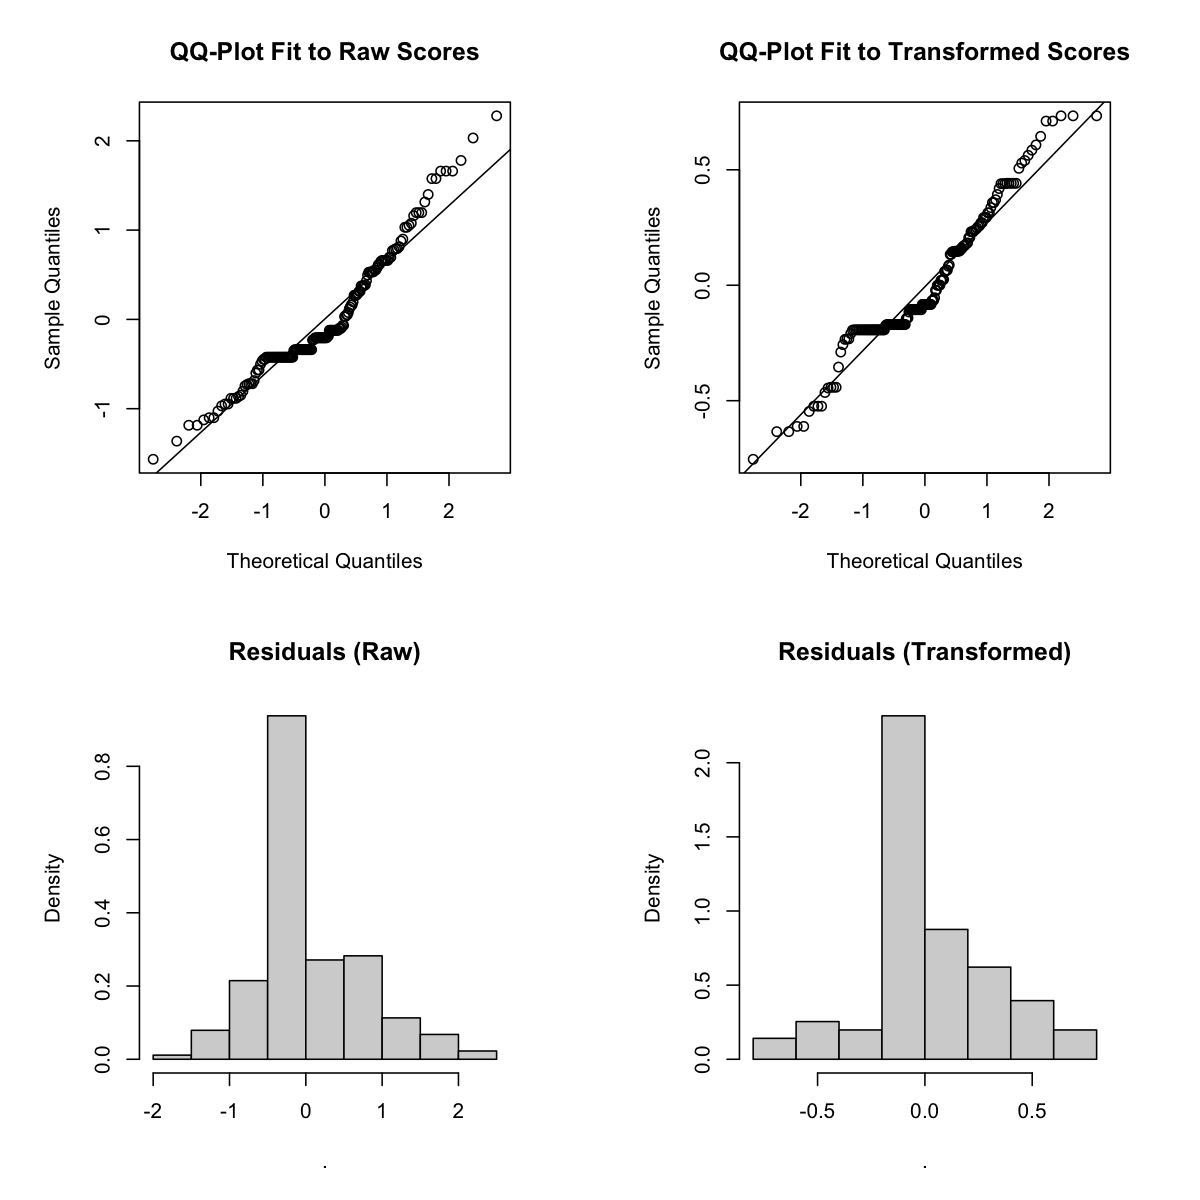

In [38]:
gov_distrust$sp_complacency$emm_back
gov_distrust$sp_complacency$emm_diff_back
plot_qqs_hist(gov_distrust$sp_complacency)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.97 0.104 190     2.76     3.17
 Control       2.80 0.116 190     2.57     3.03

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.623) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.168 0.146 190   1.153  0.2502

Results are averaged over the levels of: wave 

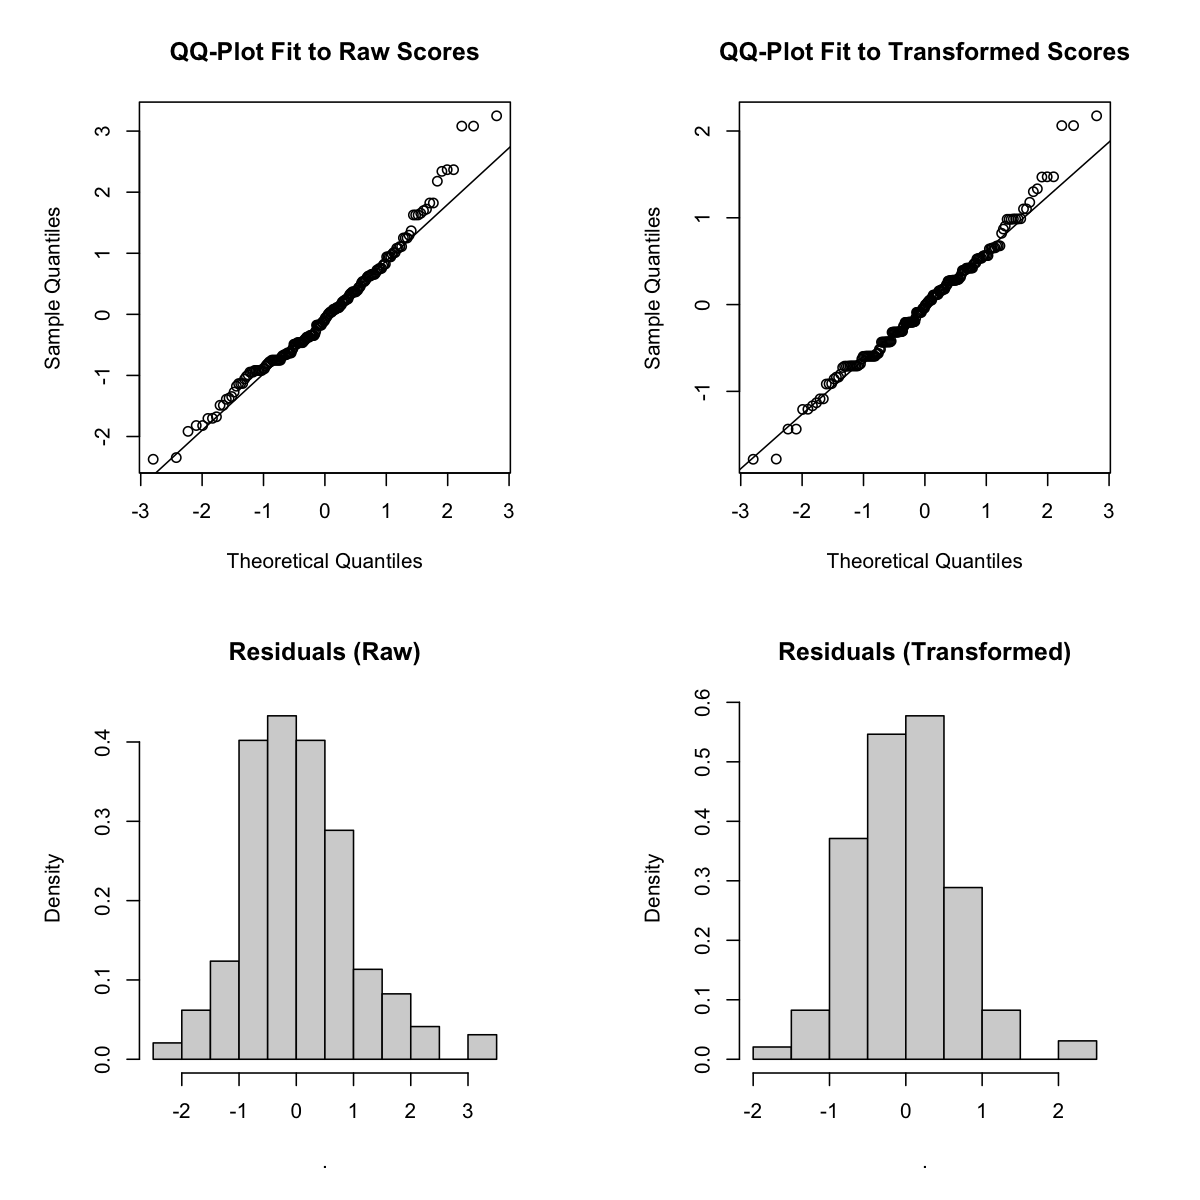

In [39]:
gov_trust$sp_complacency$emm_back
gov_trust$sp_complacency$emm_diff_back
plot_qqs_hist(gov_trust$sp_complacency)

### PHI Trust Views

In [40]:
vcf_data %>% group_by(phi_trust_cat) %>% count()
vcf_data %>% group_by(phi_trust_cat, group) %>% count()
vcf_data %>% group_by(phi_trust_cat) %>% 
    summarise(n = n(), 
              rep_n = sum(republican == "rep"),
              perc = rep_n/n)

phi_trust_cat n  
1 distrusting   119
2 trusting      252

phi_trust_cat group     n  
1 distrusting   Treatment  65
2 distrusting   Control    54
3 trusting      Treatment 141
4 trusting      Control   111

phi_trust_cat n   rep_n perc     
1 distrusting   119 63    0.5294118
2 trusting      252 84    0.3333333

In [41]:
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "trusting") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "trusting") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "trusting") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "trusting") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 141 2.1 (1.6) 3 (2.4)   0.9 (2.1) 0.52              0.000
2 Control   111 2 (1.4)   2.4 (2.1) 0.4 (1.5)   NA              0.007

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 141 2.3 (1.6) 3.1 (1.9) 0.8 (1.7) 0.45              0.000
2 Control   111 2.2 (1.7) 2.5 (1.9) 0.3 (1.5)   NA              0.021

group     N   baseline 6_wk      mean_diff change_score_diff p
1 Treatment 141 2.3 (1)  2.8 (1.2) 0.5 (0.9) 0.18              0
2 Control   111 2.1 (1)  2.5 (1.1) 0.3 (0.9)   NA              0

group     N   baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 141 2.5 (1.1) 2.9 (1.2) 0.4 (1)   0.14              0.000
2 Control   111 2.4 (1.2) 2.7 (1.2) 0.3 (1)     NA              0.002

In [42]:
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "distrusting") %>% mutate(pre = base_intention_n, post = intention_6_n))
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "distrusting") %>% mutate(pre = base_encourage_n, post = encourage_6_n))
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "distrusting") %>% mutate(pre = base_sp_confidence_n, post = sp_confidence_6_n))
summarize_intent(data = vcf_data %>% filter(phi_trust_cat == "distrusting") %>% mutate(pre = base_sp_complacency_n, post = sp_complacency_6_n))


group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 65 1.2 (0.7) 1.2 (1)   0.1 (1)   -0.16             0.551
2 Control   54 1.2 (0.6) 1.5 (1.3) 0.2 (1.2)    NA             0.145

group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 65 1.4 (1)   1.4 (0.9) 0 (1)     -0.25             0.802
2 Control   54 1.3 (0.8) 1.5 (1.4) 0.3 (1.3)    NA             0.113

group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 65 1.4 (0.6) 1.5 (0.8) 0.1 (0.8) -0.27             0.177
2 Control   54 1.2 (0.4) 1.6 (0.9) 0.4 (0.8)    NA             0.001

group     N  baseline  6_wk      mean_diff change_score_diff p    
1 Treatment 65 1.6 (0.7) 1.7 (0.9) 0.1 (0.8) -0.05             0.284
2 Control   54 1.4 (0.7) 1.5 (0.9) 0.2 (0.8)    NA             0.130

In [43]:
phi_distrust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(phi_trust_cat == "distrusting"), 
                label = "a) Distrusting", pad = 0.6)

phi_trust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(phi_trust_cat == "trusting"), 
                label = "b) Trusting", pad = 0.6)

phi_distrust$tbl
phi_trust$tbl

[1] "Intentions to Vaccinate (mean = -0.007; 95% CI = -0.037, 0.022; P = 0.6164)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.004; 95% CI = -0.057, 0.066; P = 0.8877)"
[3] "COVID-19 Vaccine Confidence (mean = -0.121; 95% CI = -0.275, 0.033; P = 0.1218)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.015; 95% CI = -0.146, 0.176; P = 0.8501)"

[1] "Intentions to Vaccinate (mean = 0.435; 95% CI = 0.114, 0.755; P = 0.0082)"                    
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.558; 95% CI = 0.204, 0.912; P = 0.0021)"
[3] "COVID-19 Vaccine Confidence (mean = 0.216; 95% CI = 0, 0.432; P = 0.0503)"                    
[4] "COVID-19 Vaccine Complacency (mean = 0.15; 95% CI = -0.085, 0.385; P = 0.2099)"

#### ANCOVA Model Evaluation

 group     response     SE  df lower.CL upper.CL
 Treatment     1.08 0.0179 115     1.05     1.12
 Control       1.09 0.0188 115     1.06     1.13

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -6.64) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control -0.00748 0.0149 115  -0.502  0.6164

Results are averaged over the levels of: wave 

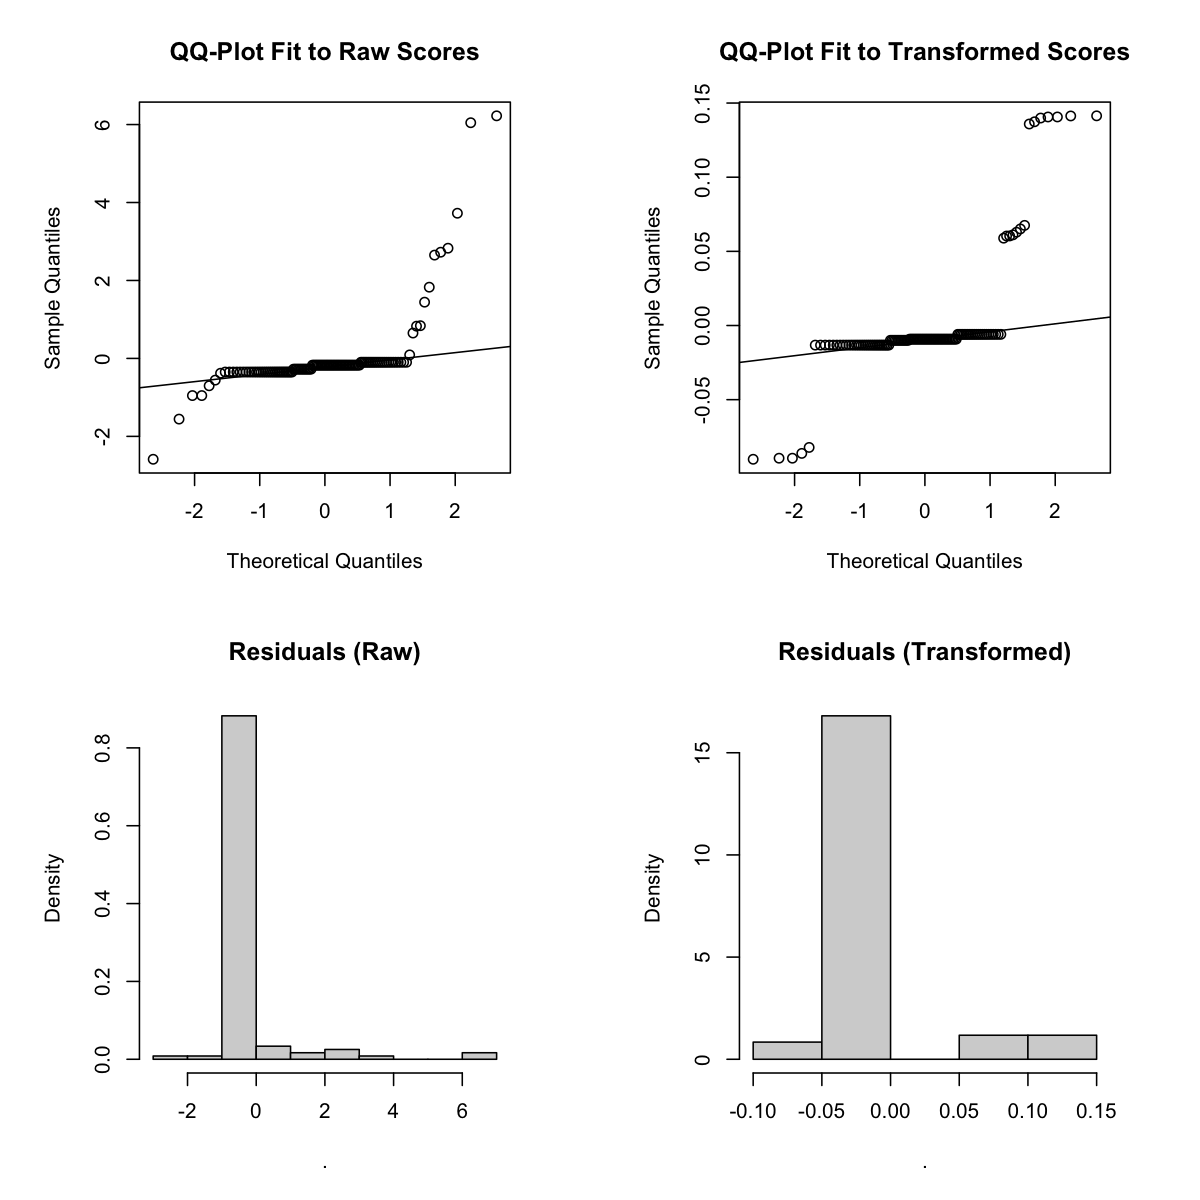

In [44]:
phi_distrust$intention$emm_back
phi_distrust$intention$emm_diff_back
plot_qqs_hist(phi_distrust$intention)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.41 0.138 247     2.16     2.71
 Control       1.97 0.119 247     1.76     2.23

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.521) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.435 0.163 247   2.667  0.0082

Results are averaged over the levels of: wave 

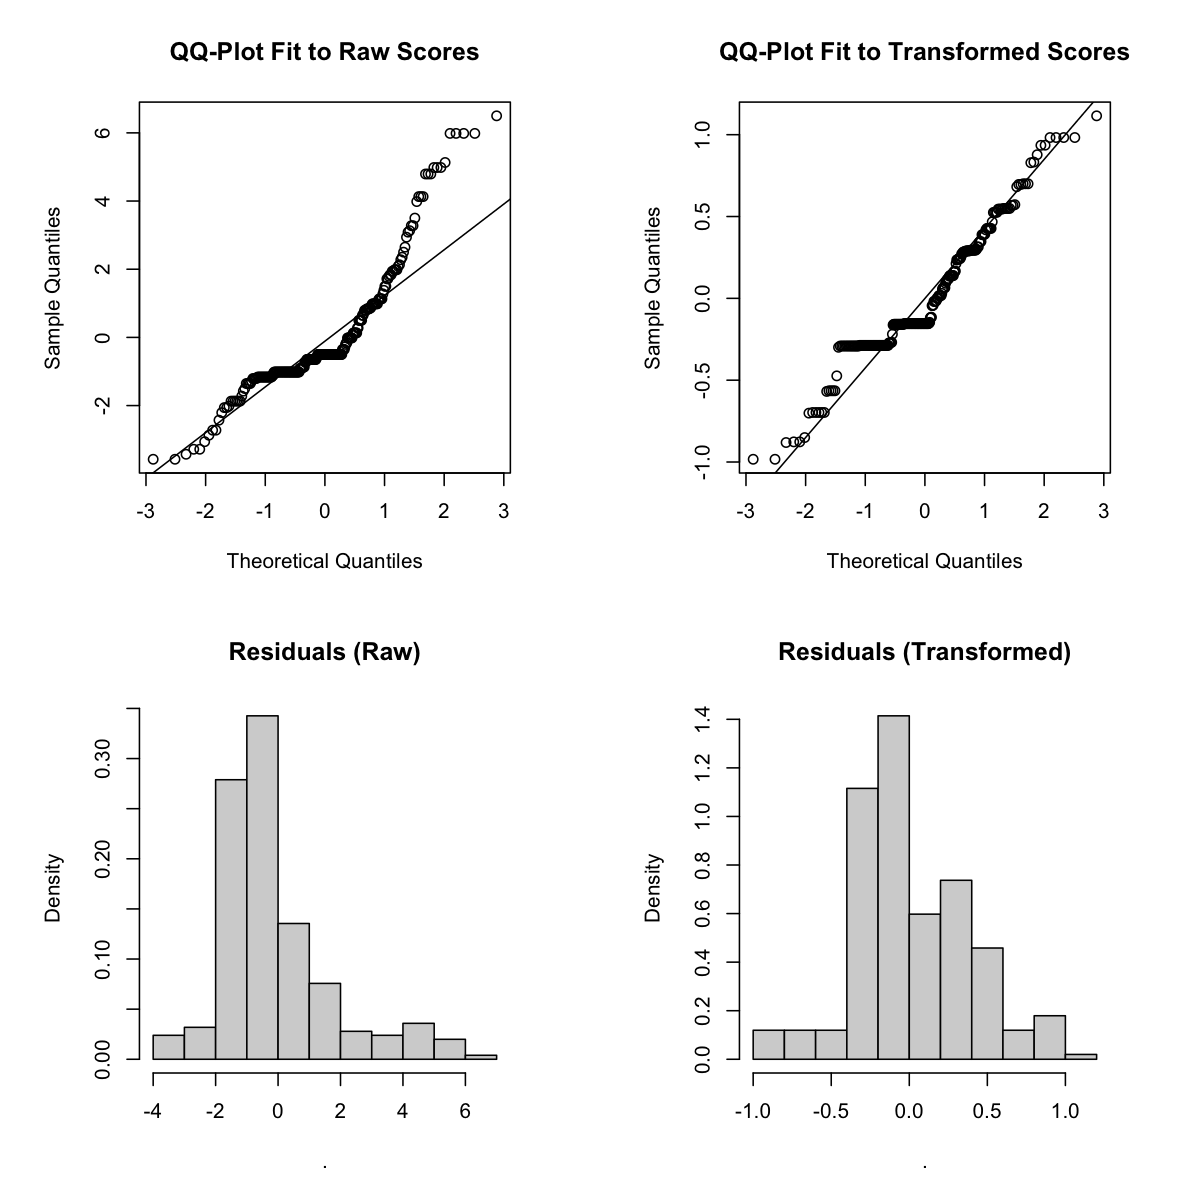

In [45]:
phi_trust$intention$emm_back
phi_trust$intention$emm_diff_back
plot_qqs_hist(phi_trust$intention)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.14 0.0325 115     1.09     1.22
 Control       1.14 0.0347 115     1.08     1.22

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -4.238) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control  0.00439 0.031 115   0.142  0.8877

Results are averaged over the levels of: wave 

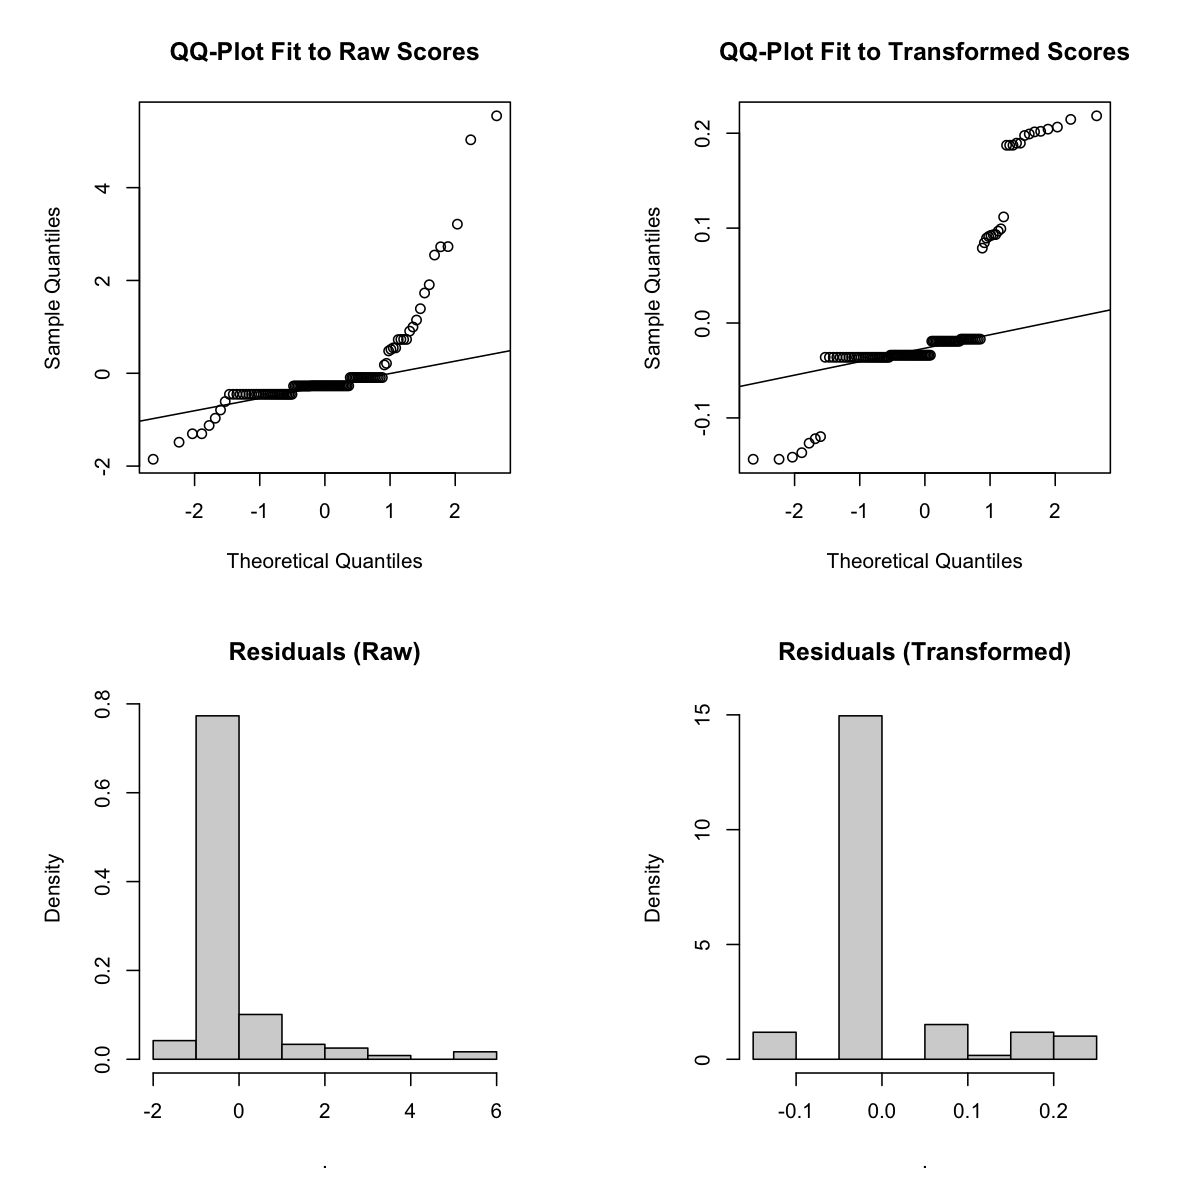

In [46]:
phi_distrust$encourage$emm_back
phi_distrust$encourage$emm_diff_back
plot_qqs_hist(phi_distrust$encourage)

 group     response    SE  df lower.CL upper.CL
 Treatment     2.75 0.143 248     2.48     3.04
 Control       2.19 0.133 248     1.94     2.47

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -0.048) scale 

 contrast            estimate   SE  df t.ratio p.value
 Treatment - Control    0.558 0.18 248   3.103  0.0021

Results are averaged over the levels of: wave 

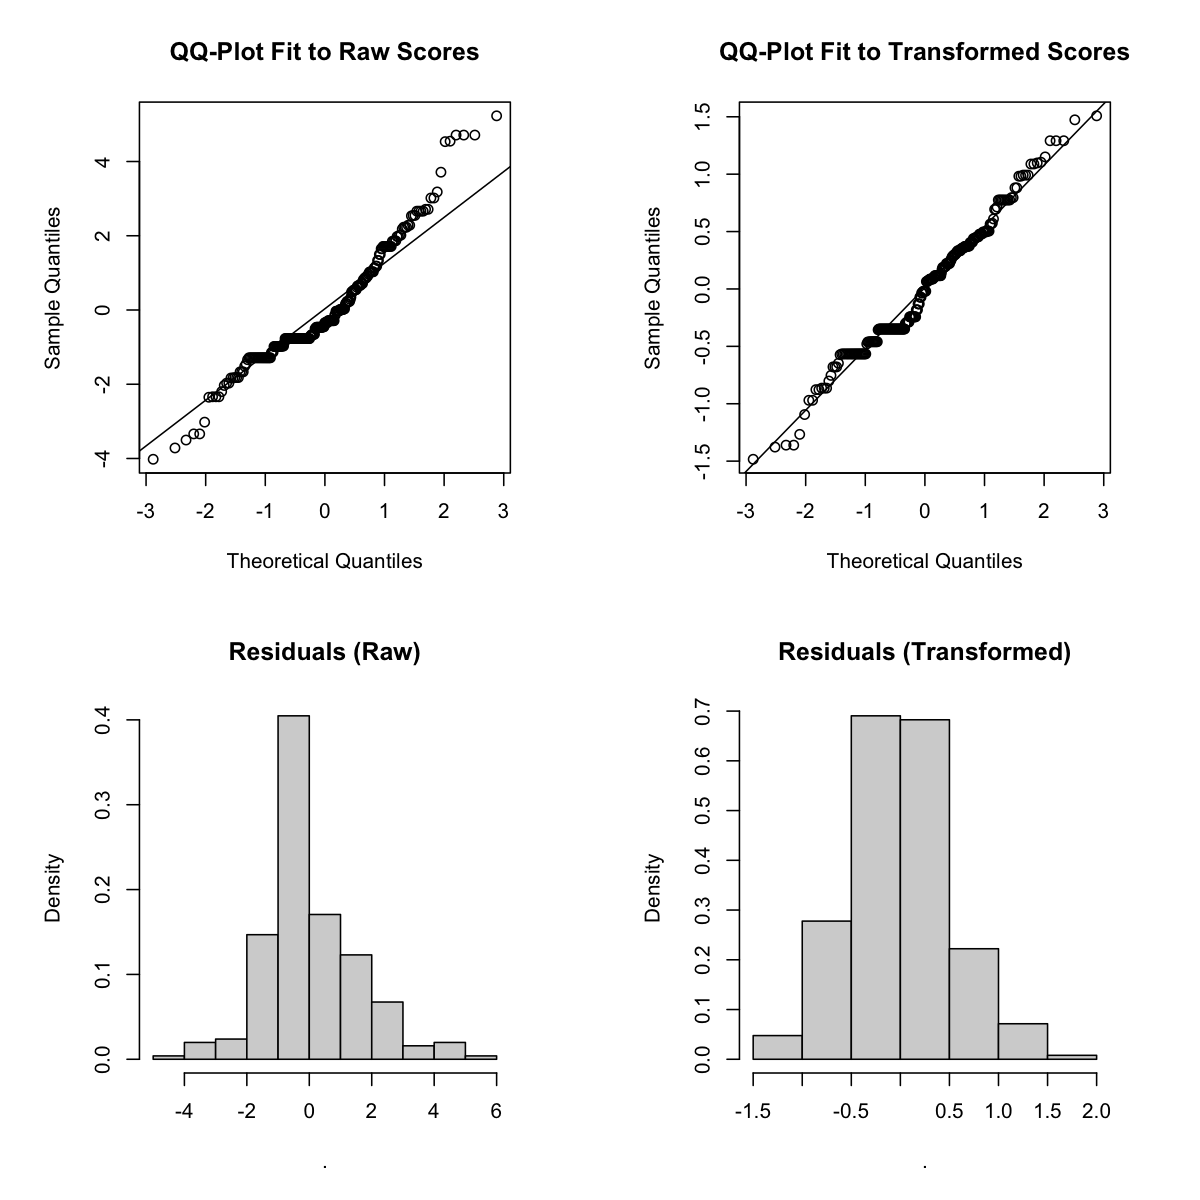

In [47]:
phi_trust$encourage$emm_back
phi_trust$encourage$emm_diff_back
plot_qqs_hist(phi_trust$encourage)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.30 0.0455 115     1.21     1.40
 Control       1.41 0.0689 115     1.29     1.57

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -1.708) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control   -0.121 0.0776 115  -1.559  0.1218

Results are averaged over the levels of: wave 

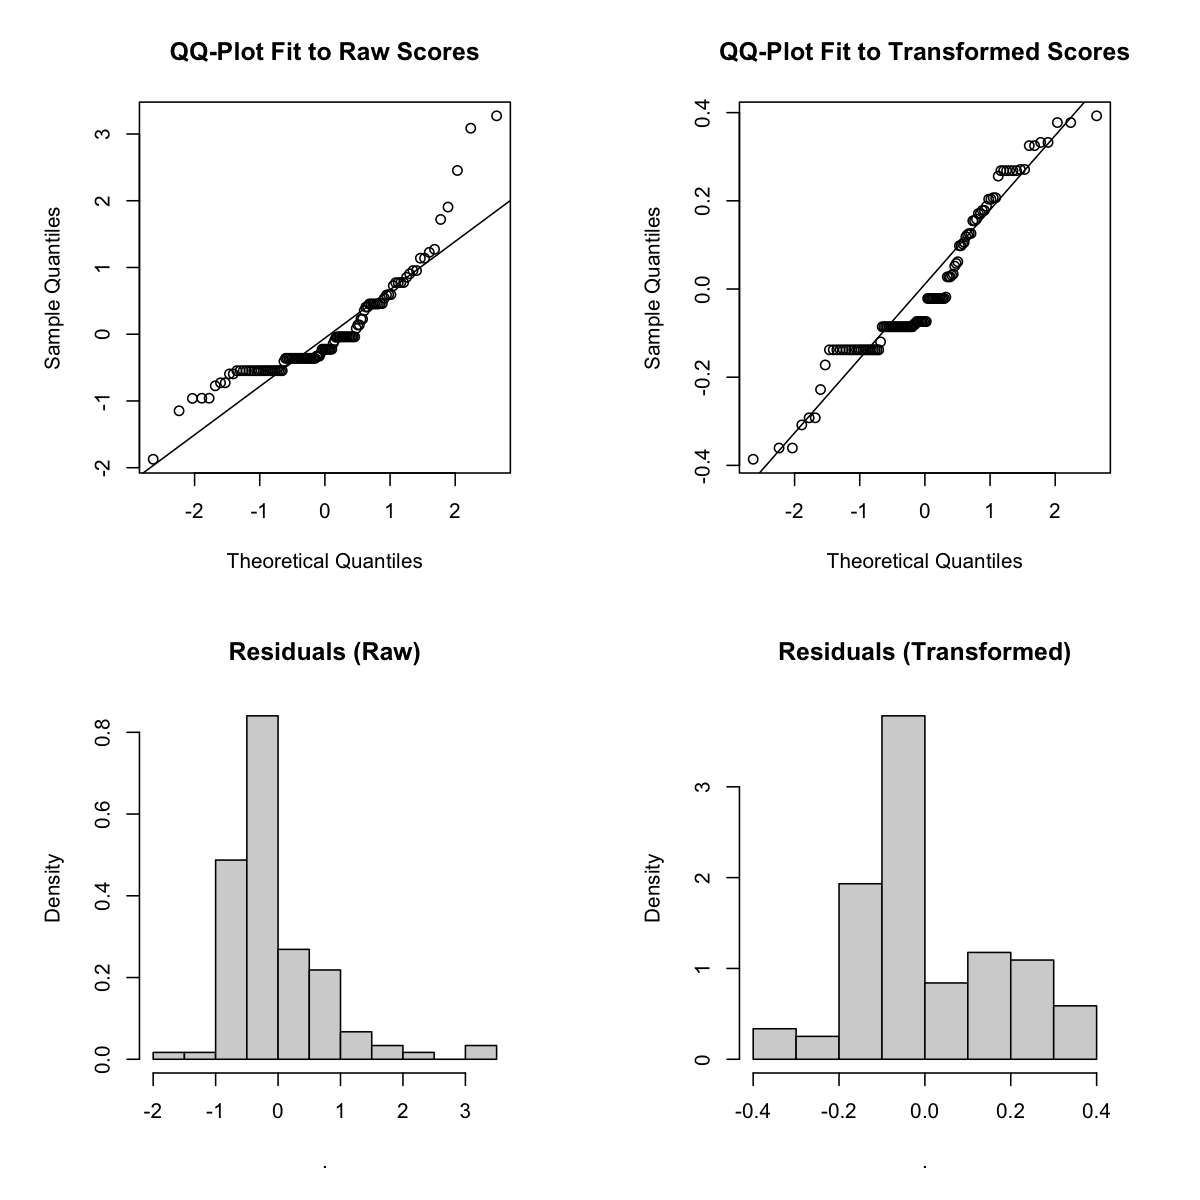

In [48]:
phi_distrust$sp_confidence$emm_back
phi_distrust$sp_confidence$emm_diff_back
plot_qqs_hist(phi_distrust$sp_confidence)

 group     response     SE  df lower.CL upper.CL
 Treatment     2.66 0.0773 248     2.51     2.81
 Control       2.44 0.0873 248     2.28     2.62

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.449) scale 

 contrast            estimate   SE  df t.ratio p.value
 Treatment - Control    0.216 0.11 248   1.967  0.0503

Results are averaged over the levels of: wave 

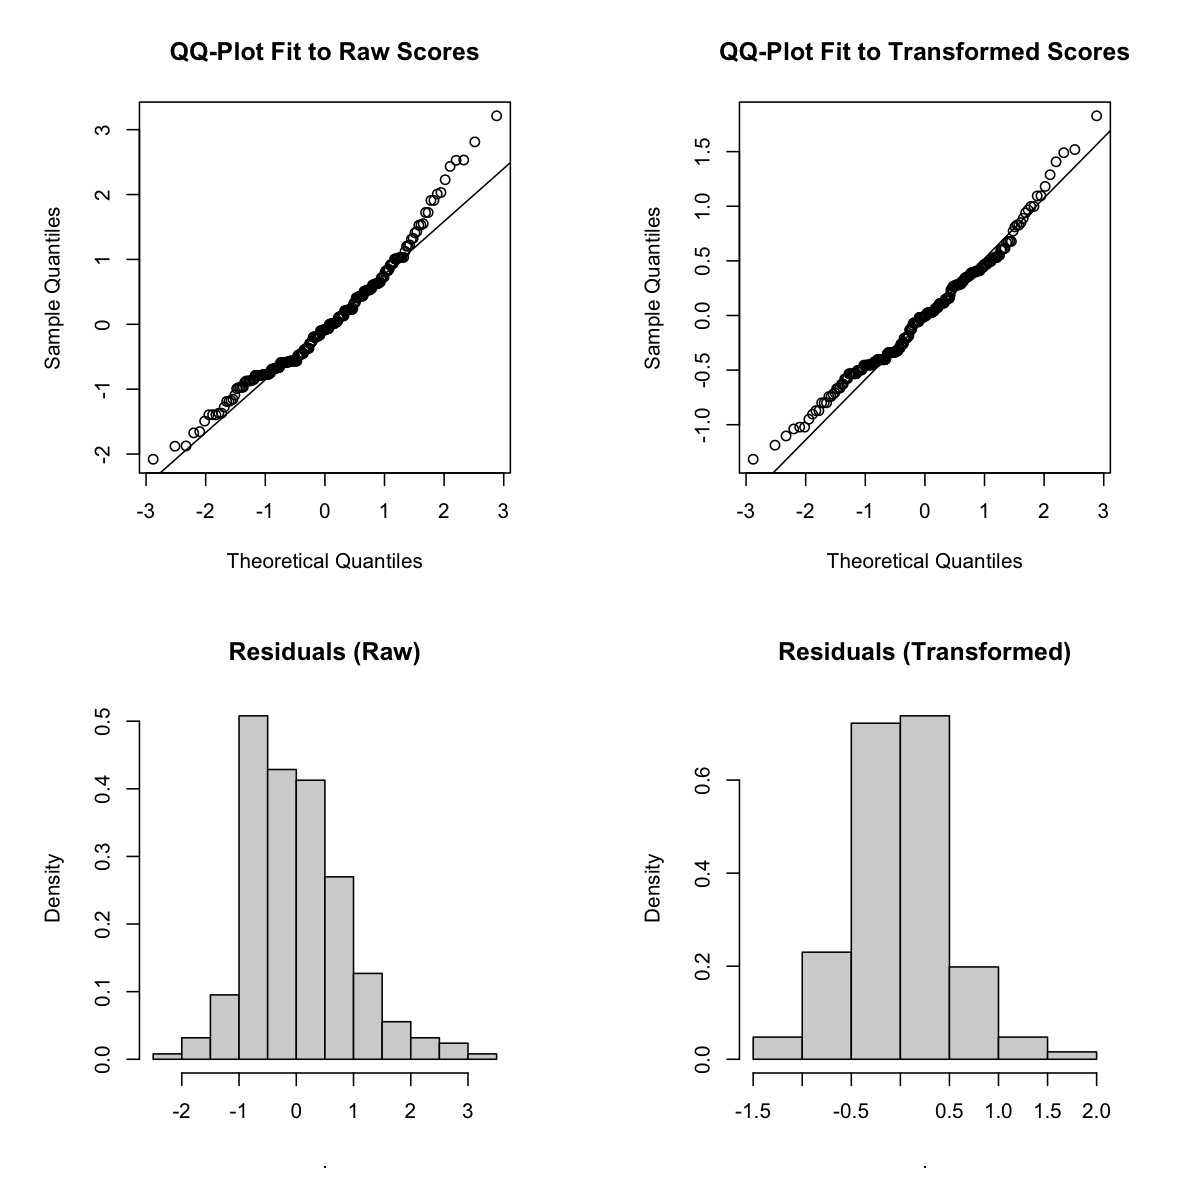

In [49]:
phi_trust$sp_confidence$emm_back
phi_trust$sp_confidence$emm_diff_back
plot_qqs_hist(phi_trust$sp_confidence)

 group     response     SE  df lower.CL upper.CL
 Treatment     1.41 0.0577 115     1.30     1.53
 Control       1.39 0.0661 115     1.27     1.54

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -1.515) scale 

 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control   0.0154 0.0812 115   0.189  0.8501

Results are averaged over the levels of: wave 

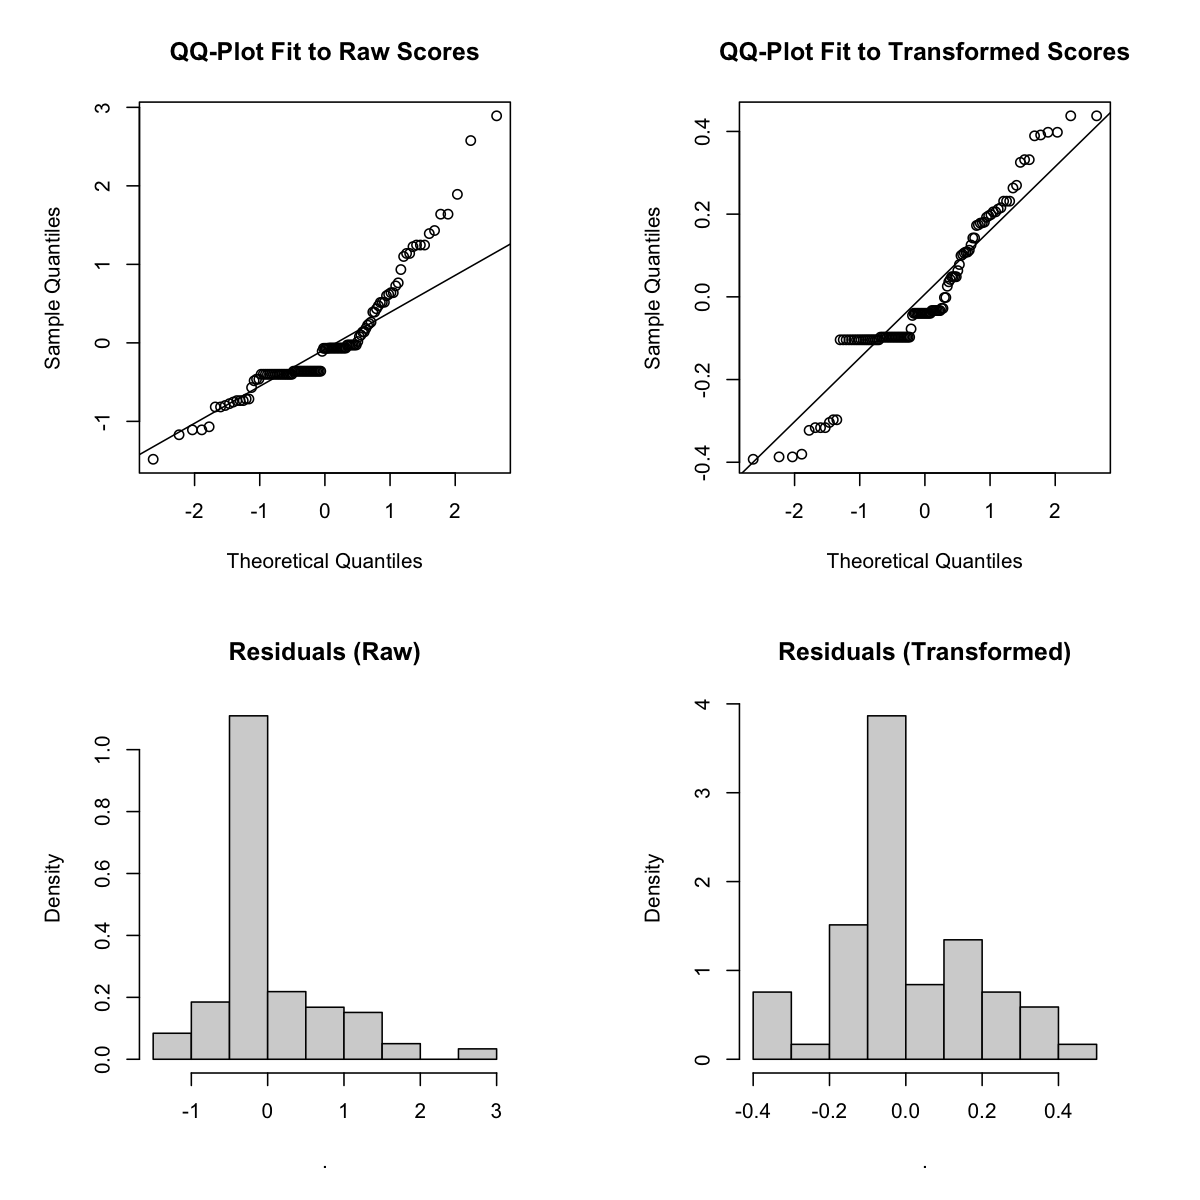

In [50]:
phi_distrust$sp_complacency$emm_back
phi_distrust$sp_complacency$emm_diff_back
plot_qqs_hist(phi_distrust$sp_complacency)

 group     response     SE  df lower.CL upper.CL
 Treatment     2.82 0.0832 248     2.66     2.98
 Control       2.67 0.0955 248     2.48     2.86

Results are averaged over the levels of: wave 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = 0.602) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control     0.15 0.119 248   1.257  0.2099

Results are averaged over the levels of: wave 

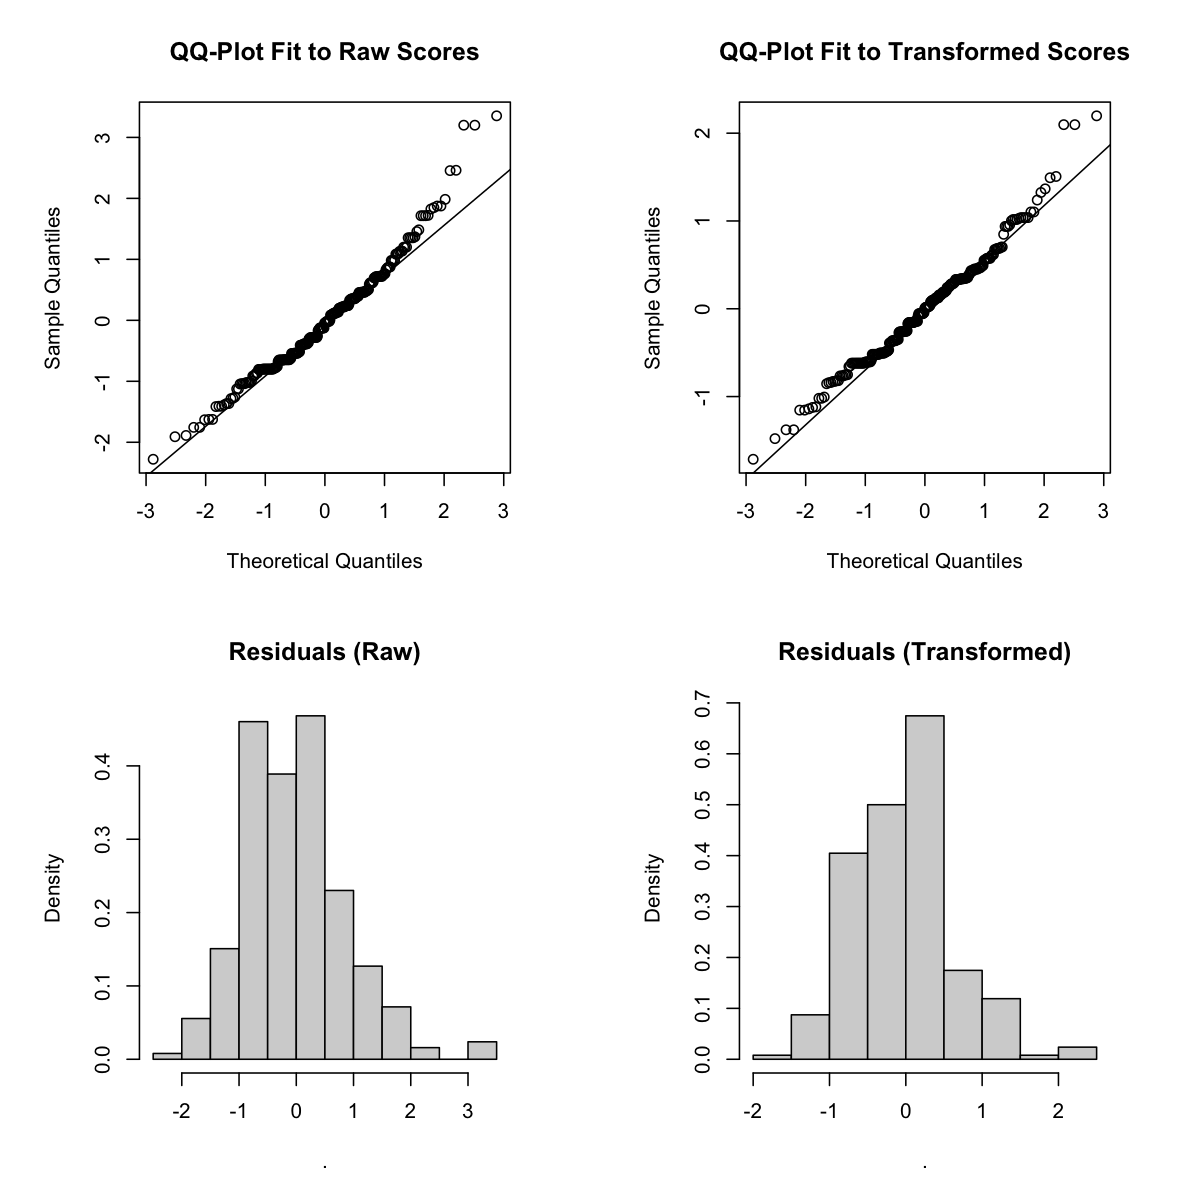

In [51]:
phi_trust$sp_complacency$emm_back
phi_trust$sp_complacency$emm_diff_back
plot_qqs_hist(phi_trust$sp_complacency)

### Summary Plots

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


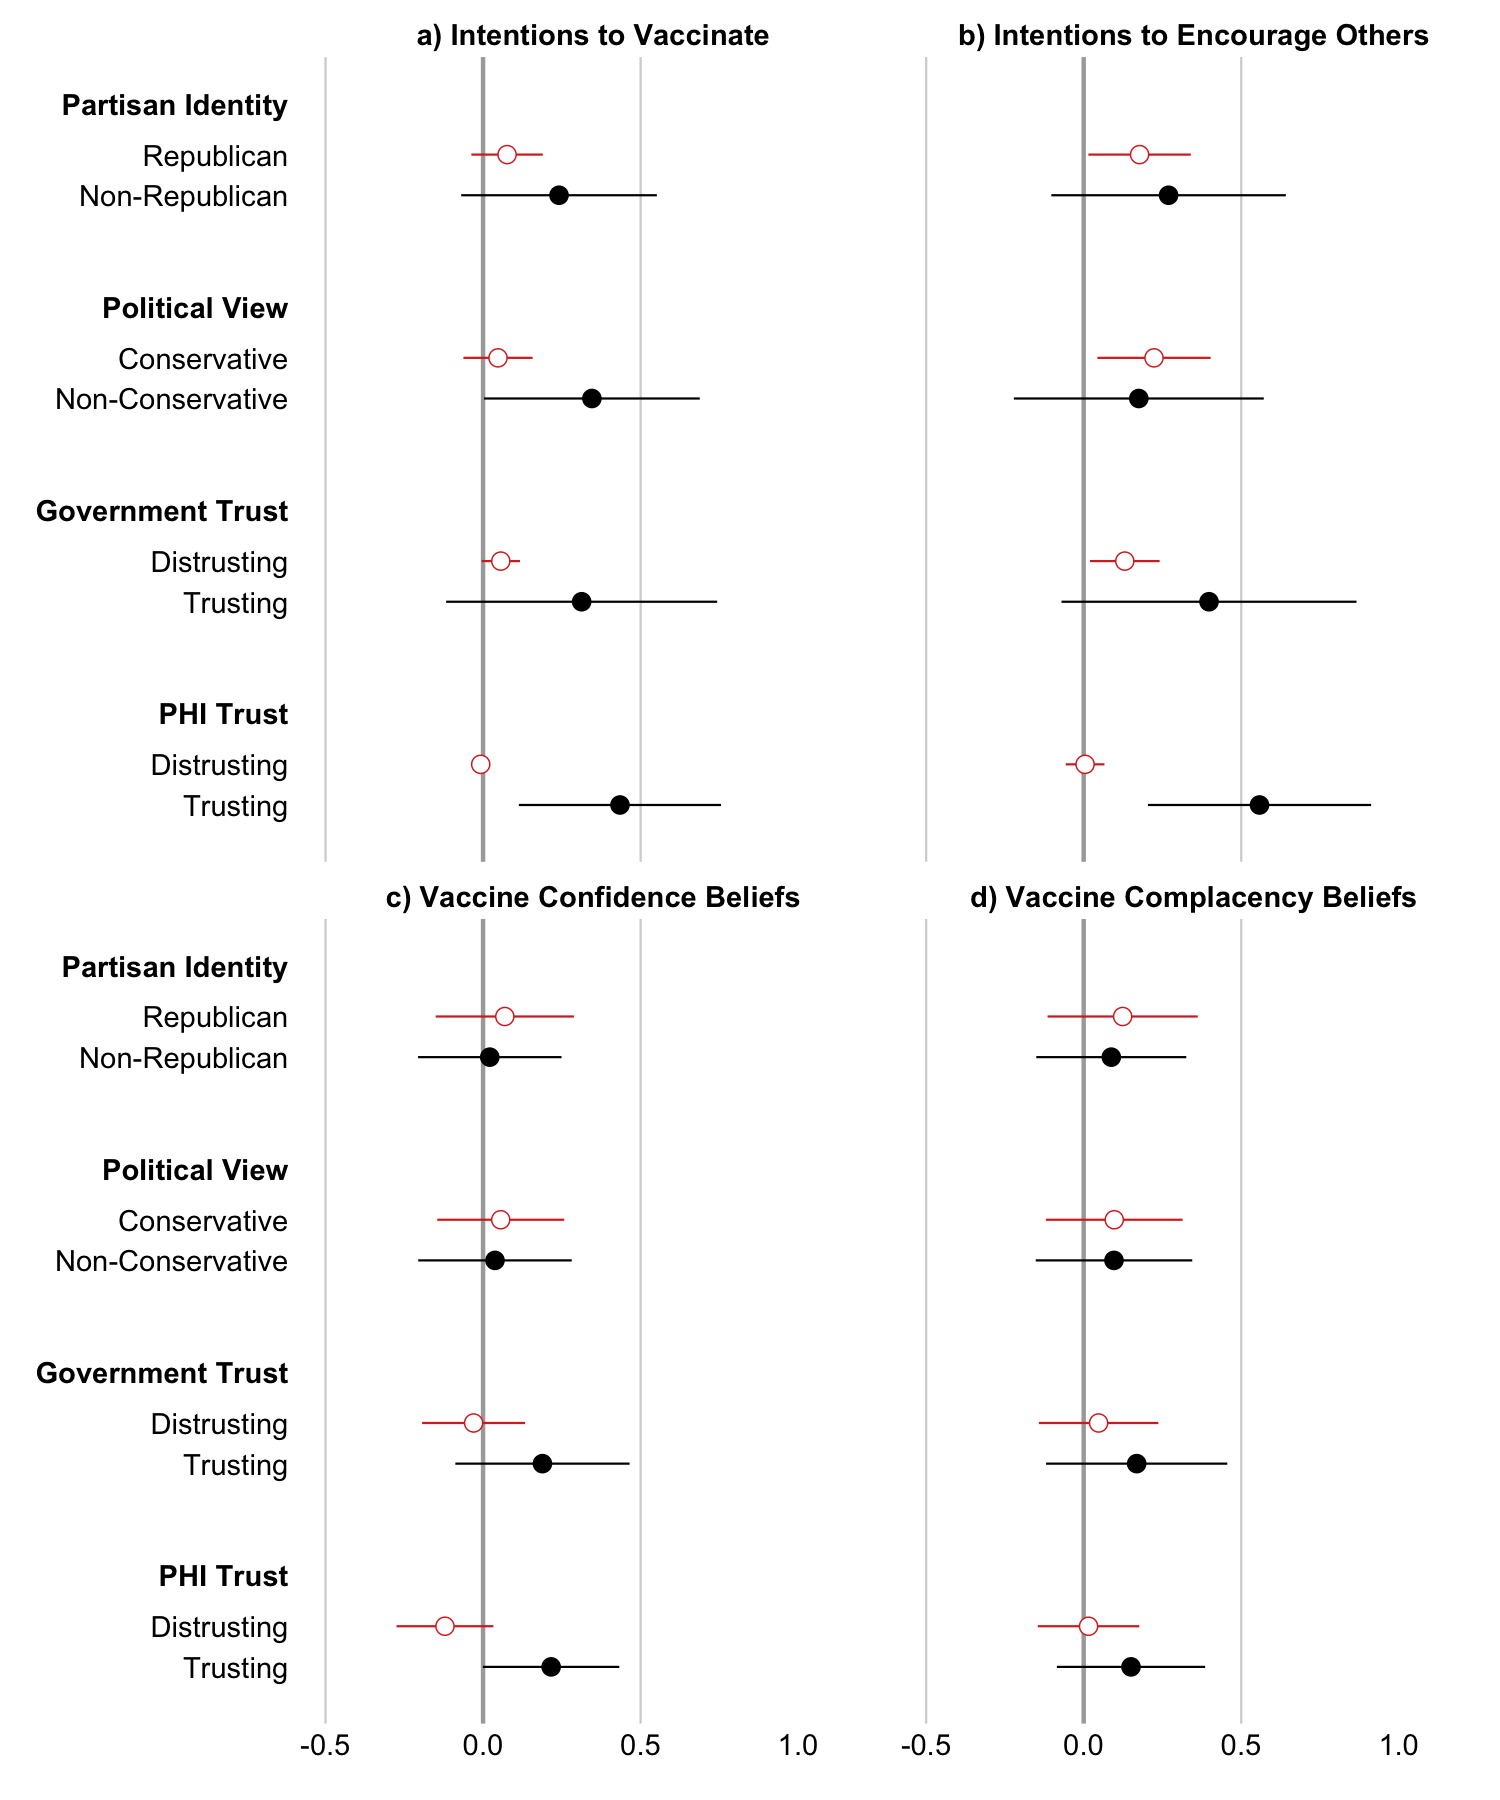

In [52]:
plot_df <- bind_rows(rep$plot_df %>% mutate(y = 4.2, subgroup = "Republican", color = "red"),
                     non_rep$plot_df %>% mutate(y = 4, subgroup = "Non-Republican", color = "black"),
                     conserv$plot_df %>% mutate(y = 3.2, subgroup = "Conservative", color = "red"),
                     non_conserv$plot_df %>% mutate(y = 3, subgroup = "Non-Conservative", color = "black"),
                     gov_distrust$plot_df %>% mutate(y = 2.2, subgroup = "Govt. Distrusting", color = "red"),
                     gov_trust$plot_df %>% mutate(y = 2, subgroup = "Govt. Trusting", color = "black"),
                     phi_distrust$plot_df %>% mutate(y = 1.2, subgroup = "PHI Distrusting", color = "red"),
                     phi_trust$plot_df %>% mutate(y = 1, subgroup = "PHI Trust", color = "black"),
                    )

plot_df$label[plot_df$label == "intention"] <- "a) Intentions to Vaccinate"
plot_df$label[plot_df$label == "encourage"] <- "b) Intentions to Encourage Others"
plot_df$label[plot_df$label == "sp_confidence"] <- "c) Vaccine Confidence Beliefs"
plot_df$label[plot_df$label == "sp_complacency"] <- "d) Vaccine Complacency Beliefs"
plot_df$label <- factor(plot_df$label, 
                        levels = c("a) Intentions to Vaccinate",
                                   "b) Intentions to Encourage Others",
                                   "c) Vaccine Confidence Beliefs",
                                   "d) Vaccine Complacency Beliefs"))

plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]

options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 150)
ggplot(data = plot_df,
       mapping = aes(x = x, y = y, group = subgroup, color = color)) +
    geom_vline(xintercept =  0, color = "darkgray", size = 1) +
    geom_vline(xintercept =  -0.5, color = "lightgray") +
    geom_vline(xintercept =  0.5, color = "lightgray") +
    geom_line() +
    geom_point(data = plot_df_means %>% filter(color == "red"),
                 mapping = aes(x = x, y = y, group = label), 
                 shape = 21, size = 3.75,  fill = "white") +
    
    geom_point(data = plot_df_means %>% filter(color == "black"),
                 mapping = aes(x = x, y = y, group = label), 
                 shape = 21, size = 3.75, fill = "black") +    
    facet_wrap(~label, ncol = 2)  +
    theme_minimal() + 
    scale_color_manual(values = c("black", "#d73027")) + 
    scale_fill_manual(values = c("#4575b4", "#d73027")) + 
    scale_y_continuous(
        breaks = c(4.45, 4.2, 4,
                   3.45, 3.2, 3,
                   2.45, 2.2, 2,
                   1.45, 1.2, 1
        ),
        labels = c("Partisan Identity", "Republican", "Non-Republican",
                   "Political View", "Conservative", "Non-Conservative",
                   "Government Trust", "Distrusting", "Trusting", 
                   "PHI Trust", "Distrusting", "Trusting"
                   ),
        limits = c(0.9, 4.5)) +
    labs(y = "", x = "") + 
    theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.x = element_text(size = 14, color= "black"),
          axis.text.y = element_text(face = c(#'bold',
                                              'bold', 'plain', 'plain',
                                              'bold', 'plain', 'plain', 
                                              'bold', 'plain', 'plain',
                                              'bold', 'plain', 'plain',
                                              'bold', 'plain', 'plain'),
                                     size = 14, color = "black"),
          strip.text.x = element_text(size = 14, face = "bold", colour = "black")
        ) +
    #theme(panel.border=element_rect(linetype=1,fill=NA)) +
    guides(color = "none") +
    theme(plot.title = element_text(hjust = 0.5)) +
    xlim(-0.5, 1.2) 

#ggsave(filename = "/Users/dankoban/Documents/trust_partisanship/mod_plot.tiff", width = 10, height = 12, device='tiff', dpi=800)
